# Kaggle Leaf Classification Challenge


In [1]:
## Install pandas if you don't already have it (uncomment line below)

! pip install pandas matplotlib scikit-image scikit-learn

In [2]:
## If you are working on Colab, data_utils can be downloaded using the command below (uncomment line below)
# ! curl -O https://raw.githubusercontent.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/master/6_Mini_Project/data_utils.py

In [3]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

import data_utils

#import sys
#sys.path.append(os.path.join('.', '..')) # Allow us to import shared custom 
#                                         # libraries, like utils.py

# Tying everything together

Now that you have learned about the most common network architectures, it is time to combine them into a more advanced model. 
It often happens that you have a combination of data that cannot easily be modeled by any single one of these types of network. Knowing how to divide the data into the right subsets, and then build a network that handles each subset efficiently can mean the difference between a great model and an unusable one. 

In this notebook, we will work on the **Kaggle Leaf Classification Challenge**, a data science competition from [`kaggle.com`](https://www.kaggle.com/) that contains several different kinds of data.
We will download the data, visualize it, and train a classifier.
A simple network with poor performance is provided for you as a starting point, but it is up to you use what you have learnt to improve the results.


## Kaggle challenge

Kaggle is a website to participate in real-world challenges.
Most competitions on Kaggle have a dataset, an accuracy metric and a leaderboard to compare submissions.
You can read more about Kaggle public datasets [here](https://www.kaggle.com/datasets).

We will undertake the [_Leaf Classification_](https://www.kaggle.com/c/leaf-classification) challenge. We report here the description of the dataset:

> The dataset consists of approximately 1,584 images of leaf specimens which have been converted to binary black leaves against white backgrounds. 
Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample.


# Get set up

**NB**: You will need a Kaggle account for this exercise!

1. Go to [Kaggle](https://www.kaggle.com/), create an account
2. [Download the dataset](https://www.kaggle.com/c/leaf-classification/data)
3. Unpack the dataset in the current directory. Structure should be as follows:
```
02456-deep-learning-with-PyTorch\4_Mini_Project
--> sample_submission.csv
--> test.csv
--> train.csv
--> images
--> --> 1.jpg
--> --> 2.jpg
--> --> 3.jpg
--> --> ...
```

# Upload data to colab
If you're running this notebook on google colab, you'll need to upload `data_utils.py` that we provide as well as the data you've just downloaded from kaggle to colab. Small files like `data_utils.py` you can simply upload via the folder icon to the left. Files that are uploaded like this, however, will be deleted every time the session ends. For big files like the kaggle data folder it's therefore better to:

1. upload the data to google drive
2. mount the google drive (see cell below)

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

After going through a quick authorization process you should now have access to the uploaded file via colab. We can check the location of our data as follows:

In [5]:
#!ls drive/'My Drive'

Let's save the path for later use. Just replace this with your local path if you're not running on colab.

In [6]:
# Since I am running locally I will use the data from the folder i am in


# Visualizing the data

First we start out by looking at the images. 
You need to load them first!
Then we load in the training data, which is in CSV format. For this, we use [pandas](https://pandas.pydata.org/).
Pandas is useful for data analysis, but we don't suggest using it in any production code.

In [7]:
image_paths = glob.glob('images/*.jpg')
print("Total Observations:\t", len(image_paths))

# now loading the train.csv to find features for each training point
train = pd.read_csv('train.csv')
train_images = ['images/{}.jpg'.format(i) for i in train.id.values]

# now loading the test.csv
test = pd.read_csv('test.csv')

Total Observations:	 1584


## Exercise 1

1.1) How many samples do we have for training and test? Do we have the same information for training and test data? How many samples do we have for each species?

**Hint**: You might want to use .shape, .columns, pd.unique() and .symmetric_difference().


In [8]:
# Getting the number of samples for training and testing
num_train_samples = train.shape[0]
num_test_samples = test.shape[0]

print(f"Number of training samples: {num_train_samples}")
print(f"Number of test samples: {num_test_samples}")


Number of training samples: 990
Number of test samples: 594


We have 990 samples of leaves for the training set and 594 for the test set. For each sample there is a number of features. 


In the following I will look at the supplied features:

In [9]:
# Displaying the names of the features
print("Features in the dataset:")
print(list(train.columns))

print("Features in test dataset:")  
print(list(test.columns))

Features in the dataset:
['id', 'species', 'margin1', 'margin2', 'margin3', 'margin4', 'margin5', 'margin6', 'margin7', 'margin8', 'margin9', 'margin10', 'margin11', 'margin12', 'margin13', 'margin14', 'margin15', 'margin16', 'margin17', 'margin18', 'margin19', 'margin20', 'margin21', 'margin22', 'margin23', 'margin24', 'margin25', 'margin26', 'margin27', 'margin28', 'margin29', 'margin30', 'margin31', 'margin32', 'margin33', 'margin34', 'margin35', 'margin36', 'margin37', 'margin38', 'margin39', 'margin40', 'margin41', 'margin42', 'margin43', 'margin44', 'margin45', 'margin46', 'margin47', 'margin48', 'margin49', 'margin50', 'margin51', 'margin52', 'margin53', 'margin54', 'margin55', 'margin56', 'margin57', 'margin58', 'margin59', 'margin60', 'margin61', 'margin62', 'margin63', 'margin64', 'shape1', 'shape2', 'shape3', 'shape4', 'shape5', 'shape6', 'shape7', 'shape8', 'shape9', 'shape10', 'shape11', 'shape12', 'shape13', 'shape14', 'shape15', 'shape16', 'shape17', 'shape18', 'shape19'

This fits the data description found on the website: 

File descriptions
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format
- images - the image files (each image is named with its corresponding id)

Data fields
- id - an anonymous id unique to an image
- margin_1, margin_2, margin_3, ..., margin_64 - each of the 64 attribute vectors for the margin feature
- shape_1, shape_2, shape_3, ..., shape_64 - each of the 64 attribute vectors for the shape feature
- texture_1, texture_2, texture_3, ..., texture_64 - each of the 64 attribute vectors for the texture feature

Now I check if there are any differences in the features between training and test set:

In [10]:
# Checking if training and test data have the same columns
columns_diff = train.columns.symmetric_difference(test.columns)

if columns_diff.empty:
    print("Training and test data have the same columns.")
else:
    print(f"Columns present in one but not the other: {columns_diff}")


Columns present in one but not the other: Index(['species'], dtype='object')


It makes sense that the training data set has the extre species feature as this it the target feature we which to identify on the test dataset 

Now I will see how each species is represented in the training dataset, meaning printing how many of each species are in the dataset. To further enhance the understanding I will also do a barplot. 

Number of samples for each species in the training set:
species
Acer_Opalus                    10
Crataegus_Monogyna             10
Acer_Mono                      10
Magnolia_Heptapeta             10
Acer_Capillipes                10
                               ..
Alnus_Rubra                    10
Rhododendron_x_Russellianum    10
Cytisus_Battandieri            10
Liriodendron_Tulipifera        10
Sorbus_Aria                    10
Name: count, Length: 99, dtype: int64


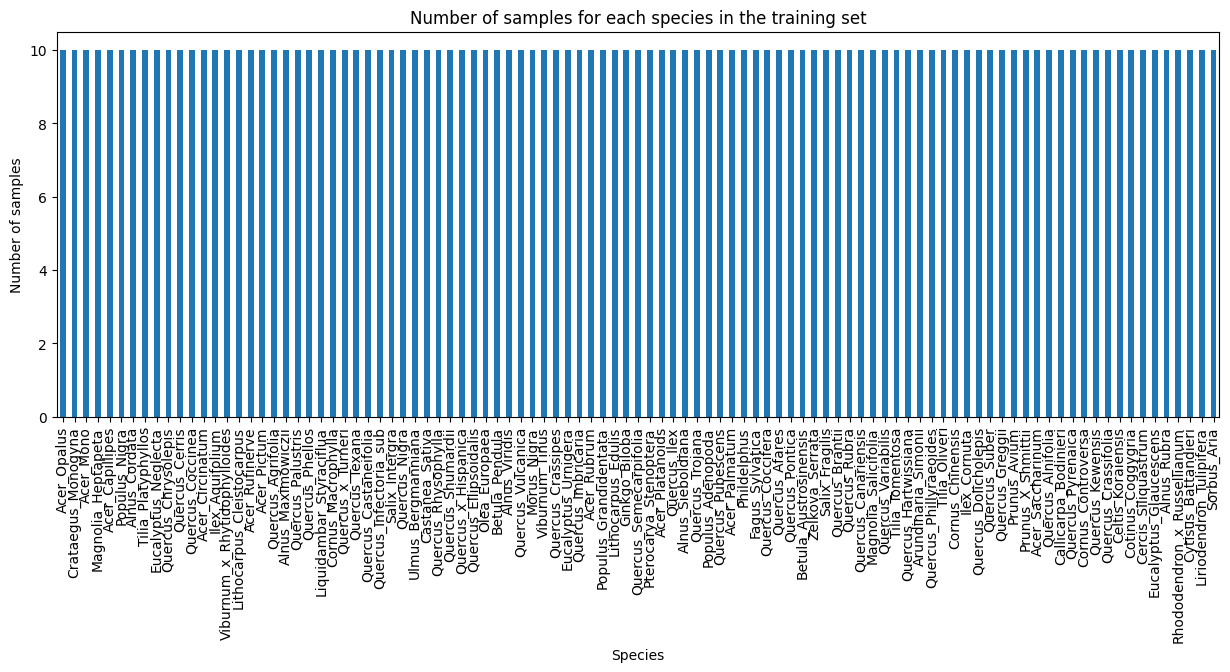

In [11]:
# Counting the number of samples for each species in the training set
species_counts = train['species'].value_counts()

print("Number of samples for each species in the training set:")
print(species_counts)

# Doing a barplot of the species counts
species_counts.plot(kind='bar', figsize=(15, 5))
plt.title("Number of samples for each species in the training set")
plt.ylabel("Number of samples")
plt.xlabel("Species")
plt.show()



I conclude that all species are equally represented in the training dataset with 10 samples each. 

With our training data and images loaded into memory.
It is time to take a look at the data.
Trying to classify leaves does not sound like a particularly difficult or interesting problem.
We have probably all had teachers forcing us to do it on field trips as children.

But try to take a look at **all** the different categories and come up with a system that discerns **all** types of leaves from each other. (In fact, distinguishing crops from weed using AI is already a thing: [weed-killing AI](https://www.cnbc.com/2018/06/04/weed-killing-ai-robot.html).)

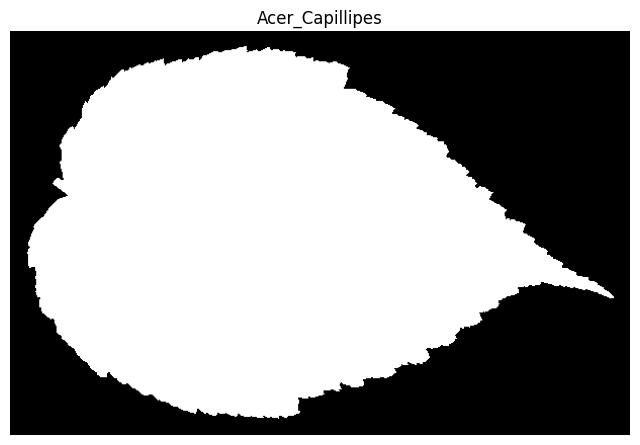

Image shape: (399, 613)


In [12]:
# First we find an example of each species in order to visualize it
species = np.array(sorted(train.species.unique()))
species_examples = [np.random.choice(train[train.species == s].id.values) for s in species]

# if on windows, replace '/' with '\\'
if os.name == 'nt':
    image_paths = [path.replace("\\", "/") for path in image_paths]


# Then we gather its index in our list of images in order to find the correct image
indexes = [image_paths.index('images/{}.jpg'.format(i)) for i in species_examples]

# Display the first image
plt.figure(figsize=(8, 8))
image = imread(image_paths[indexes[0]], as_gray=True)
plt.imshow(image, cmap='gray')
plt.title("%s" % (species[0]))
plt.axis('off')
plt.show()

# print image shape
print("Image shape:", image.shape)

## Exercise 2
2.1) In general it is a good approach to visualize an image for each category to get a better feeling of the task. You should now write some code to show 1 image from each category. You might want to use plt.subplot().

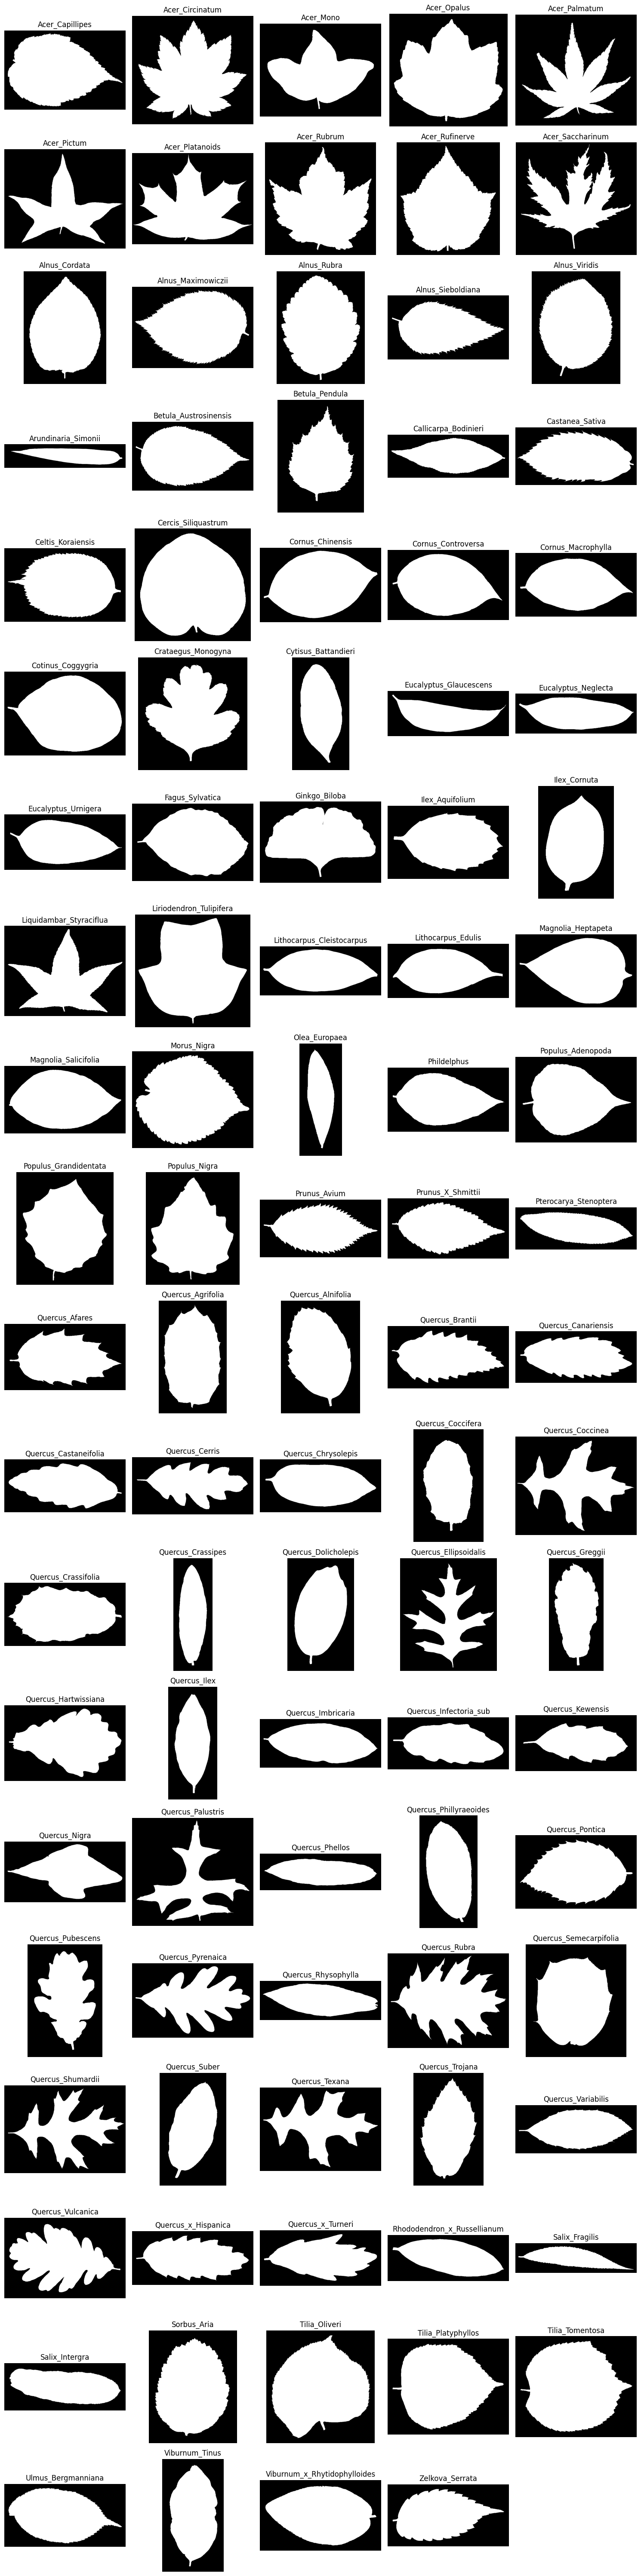

In [13]:
# Now plot 1 image from each category
# Set up the plot grid
num_species = len(species)
cols = 5  # Number of columns for the plot
rows = (num_species // cols) + 1  # Calculate required number of rows

# Create a plot
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
axes = axes.flatten()  # Flatten to iterate over all subplots

for i, idx in enumerate(indexes):
    # Read and plot the image
    image = imread(image_paths[idx], as_gray=True)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(species[i])
    axes[i].axis('off')  # Hide the axes for a cleaner look

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



As you can see, classifying leaves is actually a very tough problem.
What makes it even worse is that we cannot use all the image data we have available.
In order to decrease the amount of computation needed, we need to reduce the size of the images as much as possible.
On top of that, our neural network usually only accepts fixed-size input tensors.
This means we will have to change the shape of the images so that they all have the same sizes.


Resizing is problematic because it alters the shape of the leaves, and for some of them, this is their most distinctive feature. Take a look at `Salix_Intergra` in the bottom left corner.
Describing this leaf without taking its shape into account seems extremely difficult.

Therefore we will 
1. first pad all the images into squares, and
2. then resize them.

## Exercise 3

3.1) **Find an appropriate image size**. Test various resizings of the image until you have found the smallest resizing of the image where you "can still differentiate between the images".
How small is too small should ultimately be determined by an actual test, but what makes sense visually is probably a good place to start.
Change the `image_size = (?, ?)` parameter below, and note your choice.
 * **Answer:**


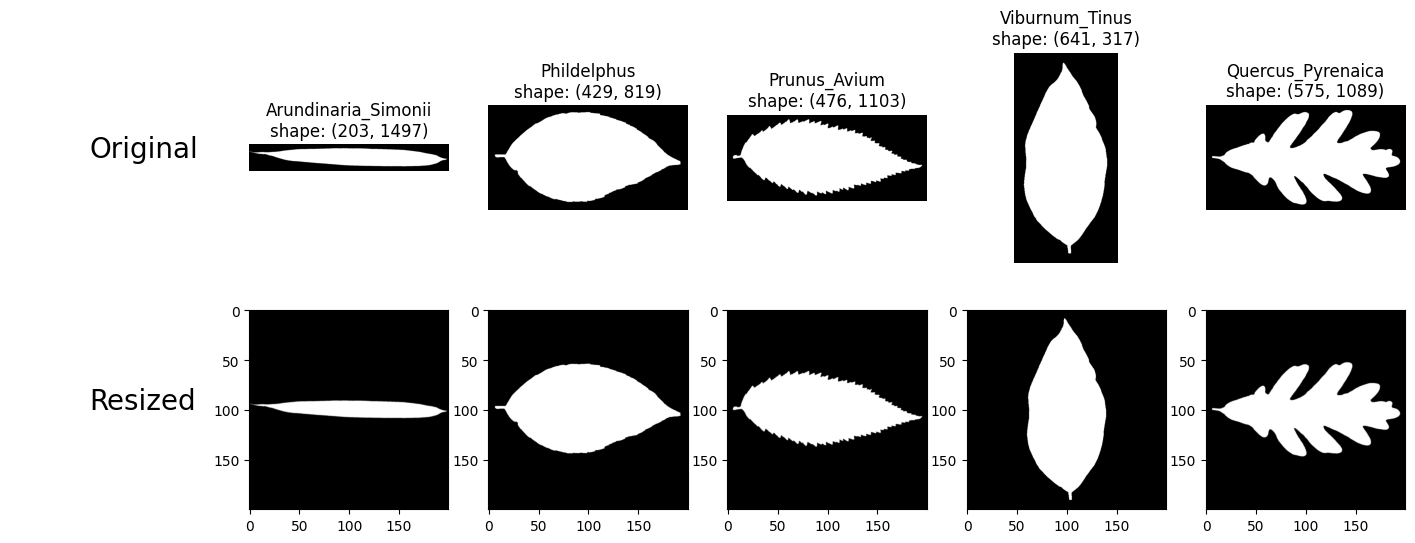

In [14]:
# Define the desired size for resizing the images (width, height)
image_size = (200, 200)  # <-- YOUR CODE HERE

# Number of images to display
amount = 5

# Randomly select 'amount' images from the list of training images
image_sample = np.random.choice(train_images, amount)

# Define the size of the entire figure (width, height in inches)
fig = plt.figure(figsize=(18, 6))

# Add a title to the first row: "Original"
ax = plt.subplot(2, amount + 1, 1)  # Create an empty subplot at position (1, 1)
txt = ax.text(0.4, 0.5, 'Original', fontsize=20)  # Add text "Original" to label the section
txt.set_clip_on(False)  # Prevent the text from being clipped by the subplot boundary
plt.axis('off')  # Hide the axes for a clean display

# Loop through the selected images to display the originals
for i, path in enumerate(image_sample):
    plt.subplot(2, amount + 1, i + 2)  # Create a subplot for each image in the first row
    image = imread(path, as_gray=True)  # Read the image in grayscale
    plt.imshow(image, cmap='gray')  # Display the image in grayscale
    # Extract the image ID to find the corresponding species name
    _id = int(path.split('/')[-1].split('.')[0])
    # Set the title with the species name and the original image shape
    plt.title("{0}\nshape: {1}".format(train[train.id == _id].species.values[0], image.shape))
    plt.axis('off')  # Hide the axes for a clean display

# Add a title to the second row: "Resized"
ax = plt.subplot(2, amount + 1, len(image_sample) + 2)  # Create an empty subplot at the start of the second row
txt = ax.text(0.4, 0.5, 'Resized', fontsize=20)  # Add text "Resized" to label the section
txt.set_clip_on(False)  # Prevent the text from being clipped by the subplot boundary
plt.axis('off')  # Hide the axes for a clean display

# Loop through the selected images to display the resized versions
for i, path in enumerate(image_sample):
    i += len(image_sample) + 3  # Calculate the position for each subplot in the second row
    plt.subplot(2, amount + 1, i)  # Create a subplot for each resized image
    image = imread(path, as_gray=True)  # Read the image in grayscale
    image = data_utils.pad2square(image)  # Pad the image to make it square
    # Resize the padded image to the defined 'image_size' with anti-aliasing for quality
    image = resize(image, output_shape=image_size, mode='reflect', anti_aliasing=True)
    plt.imshow(image, cmap='gray')  # Display the resized image in grayscale

# Show the figure with both the original and resized images
plt.show()

**I Choose a image sizer of 300x300 as this seems a good middelway between reducing the number of pixels and still keeping a high enough resolution to see the small edges**

## Investigating the other features

Now that we have looked at the image data we have available, it is time to take a look at the other available features. Below we choose a random subset of the training data, and visualize the 3 types of available features:
* margin
* shape
* texture

Run it a few times to try and get an understanding of how the features differ from species to species.

In [15]:
pip install ipywidgets


Note: you may need to restart the kernel to use updated packages.


In [16]:
import ipywidgets as widgets
from IPython.display import display

In [17]:
# Extract features
X = train.values
species = X[:, 1:2]
margin = X[:, 2:66]
shape = X[:, 66:130]
texture = X[:, 130:]

# Set the number of images to show at a time
amount = 20

# Create scrollable widgets for each feature category
output_widgets = []

for i, idx in enumerate(np.random.choice(range(len(train)), amount)):
    output = widgets.Output()  # Create an Output widget
    with output:
        # Set up a figure for each row
        fig, axes = plt.subplots(1, 4, figsize=(24, 2.5))
        
        # Display the species name
        ax = axes[0]
        ax.text(0.2, 0.5, species[idx][0], fontsize=15)
        ax.axis('off')
        if i == 0:
            ax.set_title('Species', fontsize=20)
        
        # Display the margin features
        ax = axes[1]
        ax.plot(margin[idx])
        ax.axis('off')
        if i == 0:
            ax.set_title('Margin', fontsize=20)
        
        # Display the shape features
        ax = axes[2]
        ax.plot(shape[idx])
        ax.axis('off')
        if i == 0:
            ax.set_title('Shape', fontsize=20)
        
        # Display the texture features
        ax = axes[3]
        ax.plot(texture[idx])
        ax.axis('off')
        if i == 0:
            ax.set_title('Texture', fontsize=20)
        
        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()
    
    output_widgets.append(output)

# Display all scrollable rows in a vertical box layout
scrollable_box = widgets.VBox(output_widgets, layout=widgets.Layout(max_height='600px', overflow='auto'))
display(scrollable_box)

In [18]:
# Examine X
print(X)

[[1 'Acer_Opalus' 0.007812 ... 0.004883 0.0 0.025391]
 [2 'Pterocarya_Stenoptera' 0.005859 ... 0.000977 0.039062 0.022461]
 [3 'Quercus_Hartwissiana' 0.005859 ... 0.0 0.020508 0.00293]
 ...
 [1581 'Alnus_Maximowiczii' 0.001953 ... 0.027344 0.0 0.001953]
 [1582 'Quercus_Rubra' 0.0 ... 0.0 0.001953 0.00293]
 [1584 'Quercus_Afares' 0.023438 ... 0.023438 0.025391 0.022461]]


## Exercise 4
So far we have learned about feed forward neural networks (FFNN), convolutional neural networks (CNN), recurrent neural networks (RNN), and transformers.

4.1) How could the `image`, `Margin`, `Shape` and `Texture` be used for classification, i.e. what kind of network type would you use for each of them, and why?
 

### **Answer:**

For all features (`Image`, `Margin`, `Shape`, and `Texture`), I would use a **Convolutional Neural Network (CNN)** since they all have topological information that CNNs are designed to capture effectively.

1. **Image**: CNNs are particularly suited for image data because they can capture spatial patterns like edges, textures, and shapes through their convolutional layers. These layers help identify both low-level and high-level features in the images, which is crucial for classification.

2. **Margin**: The margin of the leaf contains boundary information. CNNs are very effective at detecting such contours and edges, as their filters can learn to pick up boundary patterns that differentiate one class from another.

3. **Shape**: Shape information is inherently spatial and topological. CNNs can recognize geometric patterns and outlines effectively through their hierarchical structure, where deeper layers capture more complex patterns in the data.

4. **Texture**: Texture represents fine-grained patterns on the leaf surface. CNNs can apply filters at different scales to capture detailed texture features, making them suitable for analyzing the surface structure of leaves.

While other network types (e.g., FFNNs, RNNs) could be used, they are less appropriate since they do not leverage the spatial structure of the data effectively. CNNs are specifically designed to process topological information efficiently, making them the best choice for this classification task.


# Managing the data

The details of the code in this section isn't that important.
It simply manages the data in a nice way - so it is a good place to come back and look for inspiration when you will work on your own projects.


## Defining the data loader

## Exercise 5 
5.1) As a part of the data loader, we should specify the shape of the images, number of classes, and the number of features for the three feature types: margin, shape and texture. Define the three variables in the code below.

In [19]:
# The image shape should be of the format (height, width, channels)
IMAGE_SHAPE = (200, 200, 1)  # Height, width, 1 channel for grayscale images (adjust based on preprocessing choice)

# Define the number of classes (number of unique species in the dataset)
NUM_CLASSES = len(train['species'].unique())

# For all three feature types (margin, shape, and texture), define the number of features
# Assuming margin, shape, and texture have the same number of features as in the dataset
NUM_FEATURES = train.iloc[:, 2:66].shape[1]  # 64 features for each type (margin, shape, and texture)

# Print the defined variables for verification
print(f"IMAGE_SHAPE: {IMAGE_SHAPE}")
print(f"NUM_CLASSES: {NUM_CLASSES}")
print(f"NUM_FEATURES: {NUM_FEATURES}")


IMAGE_SHAPE: (200, 200, 1)
NUM_CLASSES: 99
NUM_FEATURES: 64


In [20]:
# Paths to data
TRAIN_PATH = "train.csv" 
TEST_PATH = "test.csv" 
IMAGE_PATHS = glob.glob("images/*.jpg")

# Check if data files has been stored with pickle as data.pickle
if not os.path.isfile("data.pickle"):
    print("Pickle file not found")
    print("Loading data from scratch")
    # train holds both X (input) and t (target/truth)
    data = data_utils.load_data(train_path=TRAIN_PATH, 
                                test_path=TEST_PATH,
                                image_paths=IMAGE_PATHS,
                                image_shape=IMAGE_SHAPE[:2])
    # to visualize the size of the dimensions of the data
    print("\n@@@Shape checking of data sets@@@")
    print("TRAIN")
    print("\timages\t%s%f" % (data.train['images'].shape, data.train['images'].mean()))
    print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
    print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
    print("\ttextures%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
    print("\tts\t %s" % (data.train['ts'].shape))
    print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
    print("TEST")
    print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean())) 
    print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
    print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
    print("\ttextures%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
    print("\tids\t%s" % (data.test['ids'].shape))

    

**I now wish to produce some custom features. BELOW IS A VERY DETAILED WALKTHROUGH OF THE FEATURES CALCULATED. PLEASE ONLY EXPAND IT IF YOU ARE CURIOUS**

## Custom Feature Extraction for Leaf Classification

To enhance our model's ability to differentiate between the different leaf species, we crafted additional features based on the geometric properties, texture, and edge characteristics of each leaf image. These custom features provide more detailed information that complements the existing 64-dimensional margin, shape, and texture vectors. Below is a detailed explanation of each custom feature and how it is calculated.

### 1. **Aspect Ratio**

**Definition**: The aspect ratio is defined as the ratio of the width to the height of the bounding box that encloses the leaf. It provides insight into the general shape of the leaf, helping to distinguish between species that are elongated versus those that are more circular.

**Calculation**:
- Using the `skimage.measure.regionprops` function, we extract the `minor_axis_length` (width) and `major_axis_length` (height) of the leaf.
- The aspect ratio is calculated as:
  
  $$\text{Aspect Ratio} = \frac{\text{minor\_axis\_length}}{\text{major\_axis\_length} + 1e-5}$$
  
  The small value `1e-5` is added to prevent division by zero.

### 2. **Convex Area**

**Definition**: The convex area is the area of the convex hull that surrounds the leaf. The convex hull is the smallest polygon that completely encloses the leaf. This feature is useful for understanding the compactness or complexity of the leaf shape.

**Calculation**:
- Using `regionprops`, we obtain the `convex_area` attribute, which represents the area covered by the convex hull of the leaf shape.

### 3. **Eccentricity**

**Definition**: Eccentricity measures how elongated a shape is. It is defined as the ratio of the distance between the foci of the ellipse that has the same second-moments as the leaf region and its major axis length. An eccentricity close to 0 indicates a circular shape, while values closer to 1 indicate more elongated shapes.

**Calculation**:
- Using `regionprops`, we extract the `eccentricity` attribute, which directly measures this property.

### 4. **Perimeter**

**Definition**: The perimeter is the total length of the boundary of the leaf. It captures the overall size and boundary complexity of the leaf, providing useful information about species with serrated or smooth edges.

**Calculation**:
- Using `regionprops`, we obtain the `perimeter` attribute, which measures the length of the leaf's boundary.

### 5. **GLCM Contrast**

**Definition**: The Gray Level Co-occurrence Matrix (GLCM) contrast measures the intensity contrast between a pixel and its neighbor over the entire image. It provides a measure of texture, where higher contrast indicates sharper differences in intensity (e.g., veins in a leaf).

**Calculation**:
- Convert the binary image to an 8-bit grayscale image.
- Use `skimage.feature.greycomatrix` to calculate the GLCM at a distance of 1 pixel in the 0-degree direction.
- Use `greycoprops` with the 'contrast' property to extract the GLCM contrast:

  $$\text{GLCM Contrast} = \sum_{i,j} p(i,j) \cdot (i - j)^2$$

  where $p(i, j)$ is the normalized GLCM.

### 6. **GLCM Correlation**

**Definition**: GLCM correlation measures how correlated a pixel is to its neighbor over the entire image. It provides insight into the degree of linear dependency between pixels at specified positions.

**Calculation**:
- Using `greycoprops` with the 'correlation' property, we extract the GLCM correlation:

  $$\text{GLCM Correlation} = \frac{\sum_{i,j} (i \cdot j \cdot p(i,j) - \mu_x \mu_y)}{\sigma_x \sigma_y}$$

  where $\mu$ and $\sigma$ are the means and standard deviations of the GLCM.

### 7. **GLCM Entropy**

**Definition**: Entropy measures the randomness or complexity of the texture in the leaf image. High entropy indicates a more complex and varied texture, while low entropy suggests uniformity.

**Calculation**:
- Calculate the GLCM as described above.
- Compute the entropy using:

  $$\text{GLCM Entropy} = -\sum_{i,j} p(i,j) \cdot \log_2(p(i,j) + 1e-10)$$

  A small value `1e-10` is added to avoid taking the logarithm of zero.

### 8. **Edge Count**

**Definition**: The edge count measures the number of edges detected in the leaf image. It helps capture details related to the serration or smoothness of the leaf's boundary.

**Calculation**:
- Use the `canny` function from `skimage.feature` to detect edges in the binary image.
- Count the number of `True` values in the resulting edge map to get the total number of edges.

### 9. **Edge Density**

**Definition**: Edge density normalizes the edge count by the total number of pixels in the image. It provides a scale-invariant measure of edge complexity, which can be especially useful when comparing leaves of different sizes.

**Calculation**:
- Compute the edge count as described above.
- Calculate the edge density using:

  $$\text{Edge Density} = \frac{\text{Edge Count}}{\text{Image Height} \times \text{Image Width}}$$

  where the image height and width correspond to the resized dimensions.

### Summary of Custom Features

| Feature             | Description                                                                            | Calculation Method |
|---------------------|----------------------------------------------------------------------------------------|--------------------|
| Aspect Ratio        | Ratio of width to height, indicating leaf elongation.                                  | `minor_axis_length / (major_axis_length + 1e-5)` |
| Convex Area         | Area of the smallest polygon enclosing the leaf.                                       | `regionprops['convex_area']` |
| Eccentricity        | Measure of how elongated the leaf shape is.                                             | `regionprops['eccentricity']` |
| Perimeter           | Total length of the leaf boundary.                                                      | `regionprops['perimeter']` |
| GLCM Contrast       | Measure of texture intensity variation.                                                 | `greycoprops(glcm, 'contrast')` |
| GLCM Correlation    | Measure of pixel correlation across the image.                                          | `greycoprops(glcm, 'correlation')` |
| GLCM Entropy        | Measure of randomness in the texture of the leaf.                                       | `-np.sum(glcm * np.log2(glcm + 1e-10))` |
| Edge Count          | Total number of detected edges in the image.                                            | `np.sum(canny(binary_image))` |
| Edge Density        | Edge count normalized by image size.                                                    | `edge_count / (image_shape[0] * image_shape[1])` |

These custom features are calculated using image processing techniques and numerical descriptors, providing a richer representation of the leaf's shape, texture, and edge characteristics. By combining these with the original margin, shape, and texture descriptors, we can provide our neural network with a more comprehensive understanding of each leaf, potentially improving its ability to classify the species accurately.

I produce the custom features in: 
First I define the augmentation

In [21]:
import pandas as pd
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import graycomatrix, graycoprops, canny
from skimage.measure import regionprops
from skimage import color

# Paths to data
TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'
IMAGE_PATHS = glob.glob('images/*.jpg')

# Define the target image shape (e.g., 200x200)
IMAGE_SHAPE = (200, 200)

# Load train and test CSVs
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

# Map IDs to their corresponding image paths for easy lookup
train_images = {row['id']: f'images/{row["id"]}.jpg' for _, row in train.iterrows()}
test_images = {row['id']: f'images/{row["id"]}.jpg' for _, row in test.iterrows()}

def calculate_custom_features(image_path, image_shape):
    """
    Calculate additional features for a given leaf image.
    
    Parameters:
    - image_path: str, path to the image.
    - image_shape: tuple, target shape (height, width) for resizing.
    
    Returns:
    - dict, containing additional features.
    """
    # Read the image
    image = imread(image_path)
    
    # Resize and convert to grayscale if needed
    image = resize(image, image_shape)
    if image.ndim == 3:
        image = color.rgb2gray(image)
    
    # Binarize the image (black leaves against white background)
    binary_image = image > 0.5
    
    # Initialize dictionary for storing features
    features = {}

    # Calculate geometric features using region properties
    properties = regionprops(binary_image.astype(int))
    if properties:
        prop = properties[0]
        features['aspect_ratio'] = prop.minor_axis_length / (prop.major_axis_length + 1e-5)
        features['convex_area'] = prop.convex_area
        features['eccentricity'] = prop.eccentricity
        features['perimeter'] = prop.perimeter
    else:
        features['aspect_ratio'] = 0.0
        features['convex_area'] = 0.0
        features['eccentricity'] = 0.0
        features['perimeter'] = 0.0

    # GLCM texture features
    glcm = graycomatrix((binary_image * 255).astype(np.uint8), [1], [0], levels=256, symmetric=True, normed=True)
    features['glcm_contrast'] = graycoprops(glcm, 'contrast')[0, 0]
    features['glcm_correlation'] = graycoprops(glcm, 'correlation')[0, 0]
    features['glcm_entropy'] = -np.sum(glcm * np.log2(glcm + 1e-10))

    # Edge detection using Canny
    edges = canny(binary_image)
    features['edge_count'] = np.sum(edges)
    features['edge_density'] = features['edge_count'] / (image_shape[0] * image_shape[1])

    return features

# Map IDs to their corresponding image paths, converting IDs to integers for matching
train_images = {int(row['id']): f'images/{int(row["id"])}.jpg' for _, row in train.iterrows()}
test_images = {int(row['id']): f'images/{int(row["id"])}.jpg' for _, row in test.iterrows()}

# Function to compute features and add them to the DataFrame
def add_features_to_df(df, image_dict, image_shape):
    extra_features = []

    # Iterate through each row in the DataFrame
    for idx, row in df.iterrows():
        image_id = int(row['id'])
        image_path = image_dict.get(image_id)
        
        if image_path and os.path.exists(image_path):
            features = calculate_custom_features(image_path, image_shape)
        else:
            print(f"Image not found for ID {image_id}")
            # Use default values if image is missing
            features = {
                'aspect_ratio': 0,
                'convex_area': 0,
                'eccentricity': 0,
                'perimeter': 0,
                'glcm_contrast': 0,
                'glcm_correlation': 0,
                'glcm_entropy': 0,
                'edge_count': 0,
                'edge_density': 0,
            }
        
        extra_features.append(features)
        
        if idx % 100 == 0:
            print(f"Processed {idx+1} / {len(df)} rows")

    # Convert the list of feature dictionaries into a DataFrame
    features_df = pd.DataFrame(extra_features)
    
    # Concatenate the new features to the original DataFrame
    df = pd.concat([df, features_df], axis=1)
    return df

#Check if train_with_extra_features.csv and test_with_extra_features.csv already exist
if os.path.isfile('train_with_extra_features.csv') and os.path.isfile('test_with_extra_features.csv'):
    print("Files already exist. Skipping feature computation.")
else:
    # Compute and add features to the training set
    print("Adding features to the training set...")
    train = add_features_to_df(train, train_images, IMAGE_SHAPE)

    # Compute and add features to the test set
    print("Adding features to the test set...")
    test = add_features_to_df(test, test_images, IMAGE_SHAPE)

    # Save the updated DataFrames back to CSV files
    train.to_csv('train_with_extra_features.csv', index=False)
    test.to_csv('test_with_extra_features.csv', index=False)

    print("Extra features added and files saved.")


Files already exist. Skipping feature computation.


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Define the features to normalize
features_to_normalize = [
    'aspect_ratio', 'convex_area', 'eccentricity', 'perimeter',
    'glcm_contrast', 'glcm_correlation', 'glcm_entropy',
    'edge_count', 'edge_density'
]

# Initialize scalers (choose MinMaxScaler or StandardScaler)
scaler = MinMaxScaler()  # For scaling to [0, 1]
# scaler = StandardScaler()  # For z-score normalization

# Fit the scaler on the training data and transform
train[features_to_normalize] = scaler.fit_transform(train[features_to_normalize])

# Apply the same transformation to the test data
test[features_to_normalize] = scaler.transform(test[features_to_normalize])

# Save the updated DataFrames back to CSV files
train.to_csv('train_with_normalized_features.csv', index=False)
test.to_csv('test_with_normalized_features.csv', index=False)

print("Normalization complete and files saved.")


#### Do you want to load your data quickly next time?
In the above cell the data is loaded, reshaped and stored as an object. If you want load this object quickly next time you should go for pickle. Pickle does effectively write an object into a character stream, so it can be loaded fastly next time. Simply replace `drive_path` with you `local_path` if you're not using colab. 

In [22]:
import pickle

# Dump the data into a pickle file in the current working directory
if not os.path.isfile("data.pickle"):
    with open('data.pickle', 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)



In [23]:
 # Load the data from a pickle file
with open('data.pickle', 'rb') as f:
    data = pickle.load(f)

## Batch Generator

While training, we will not directly access the entire dataset, instead we have a `batch_generator` function to give us inputs aligned with their targets/ids in a size that our model can handle in memory (batch\_size).

Furthermore, the `batch_generator` also handles validation splitting.

## Exercise 6
6.1) Explain shortly why the size of batches is important. You should comment on how the size of batches affect the memory, training speed, and the estimates of the gradients.
Choose a reasonable batch size the `batch_size = ?` parameter below, and note your choice.

### **Answer:**

The batch size is crucial for model training as it affects memory usage, training speed, and gradient estimates:

1. **Memory**: Larger batches require more memory, potentially exceeding available resources. Smaller batches are easier to fit in memory.

2. **Training Speed**: Larger batches process more samples at once, speeding up training per epoch. However, smaller batches allow more frequent parameter updates, which can benefit convergence.

3. **Gradient Estimates**: 
   - **Large Batches**: Provide more stable gradient estimates but can lead to smoother optimization paths, sometimes trapping the model in local minima.
   - **Small Batches**: Noisier gradients, which can help escape local minima but may slow convergence.

A reasonable batch size is **64**, balancing memory, speed, and gradient stability.

```python
batch_size = 64  # Chosen for balanced performance


In [24]:
batch_size = 64
dummy_batch_gen = data_utils.batch_generator(data, batch_size=batch_size, num_classes=NUM_CLASSES, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

print("TRAIN")
print("\timages,", train_batch['images'].shape)
print("\tmargins,", train_batch['margins'].shape)
print("\tshapes,", train_batch['shapes'].shape)
print("\ttextures,", train_batch['textures'].shape)
print("\tts,", train_batch['ts'].shape)
print()
print("VALID")
print("\timages,", valid_batch['images'].shape)
print("\tmargins,", valid_batch['margins'].shape)
print("\tshapes,", valid_batch['shapes'].shape)
print("\ttextures,", valid_batch['textures'].shape)
print("\tts,", valid_batch['ts'].shape)
print()
print("TEST")
print("\timages,", test_batch['images'].shape)
print("\tmargins,", test_batch['margins'].shape)
print("\tshapes,", test_batch['shapes'].shape)
print("\ttextures,", test_batch['textures'].shape)
print("\tids,", len(test_batch['ids']))

TRAIN
	images, (64, 200, 200, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ts, (64, 99)

VALID
	images, (64, 200, 200, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ts, (64, 99)

TEST
	images, (64, 200, 200, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ids, 64


# Build the model

In [25]:
# Load functions
! pip install torch torchvision torchaudio

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [26]:
import torch

# Define Device (CUDA, MPS, CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
    use_cuda = True
    print("Using GPU")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    use_cuda = True
    print("Using MPS")
else:
    device = torch.device('cpu')
    use_cuda = False
    print("Using CPU")

def get_variable(x):
    """ Converts tensors to the appropriate device (cuda, mps, or cpu). """
    if use_cuda:
        return x.to(device)
    return x

def get_numpy(x):
    """ Get numpy array for both cuda, mps, and cpu devices. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()


Using GPU


## Exercise 7
7.1)  Now you must define the network architecture. It is always a good idea to start simple. We recommend you to start with a mix of a convolutional layer (maybe followed by max pooling layer), a recurrent layer, and a linear output layer such that we use all the features.  

When you build the model you should be aware of the dimensions of the input and output for your different layers. The function`permute` and `view` will be very useful to rearrange your dimensions.

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
IMAGE_SHAPE = (200, 200, 1)
# Assuming the IMAGE_SHAPE is already defined
height, width, channels = IMAGE_SHAPE

# Convolutional layer parameters
conv_out_channels = 32  # Number of filters in the convolutional layer
kernel_size = 3         # Size of the convolutional kernel
conv_stride = 1         # Stride for the convolution
conv_pad = 1            # Padding for the convolution to maintain image size

# Correctly calculate features_cat_size
features_cat_size = conv_out_channels * height * width + 128 + 32  # Conv output + margin + texture + GRU output

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layer
        self.conv_1 = nn.Conv2d(in_channels=channels,
                                out_channels=conv_out_channels,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        
        # Adding a recurrent unit (GRU)
        self.rnn_1 = nn.GRU(input_size=64, hidden_size=32, batch_first=True)  # Assuming input_size = 64 for the features
        
        # Output layer
        self.l_out = nn.Linear(in_features=features_cat_size,
                               out_features=NUM_CLASSES,
                               bias=False)
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}
        
        ## Convolutional layer ##
        # Reshape input to fit the Conv2d layer
        x_img = x_img.view(-1, channels, height, width)  # Reshape to (batch_size, channels, height, width)
        x_img = self.conv_1(x_img)                       # Apply Conv2d
        x_img = F.relu(x_img)                            # Apply activation function (ReLU)
        
        # Flatten the output for the final fully connected layer
        features_img = x_img.view(x_img.size(0), -1)     # Flatten to (batch_size, conv_out_channels * height * width)
        features.append(features_img)
        
        ## Use concatenated leaf features for FFNN ##
        x = torch.cat((x_margin, x_texture), dim=1)  # Concatenate margin and texture features
        features_vector = x
        features.append(features_vector)
        
        ## Use concatenated leaf features for RNN ##
        # Concatenate shape features into a sequence suitable for the GRU
        x_shape = x_shape.unsqueeze(1)  # Add sequence dimension for GRU (batch_size, seq_len=1, input_size=64)
        rnn_out, _ = self.rnn_1(x_shape)  # Apply GRU
        features_rnn = rnn_out[:, -1, :]   # Take the last time step output
        features.append(features_rnn)
        
        ## Output layer where all features are in use ##
        features_final = torch.cat(features, dim=1)  # Concatenate all features
        
        out['out'] = self.l_out(features_final)  # Pass through the final linear layer
        return out

net = Net()
net.to(device)  # Move network to device (GPU/CPU)


Net(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rnn_1): GRU(64, 32, batch_first=True)
  (l_out): Linear(in_features=1280160, out_features=99, bias=False)
)

# Build the cost function

## Exercise 8
8.1) Since this is a classification task we will use the cross-entropy loss. Define the cross-entropy loss as the loss function in the code below.

In [28]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss()  # <-- Your code here.   

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

## Test network

#### Debugging 
The following cell might cause you some errors - try these suggestions before you try anyting else.

* **Your kernel keeps dying** on the line below it is most likely because you run out of memory.
The two most likely solutions are 
 1. reduce the image size further
 1. change your network architecture such that it uses less resources

* **`RuntimeError: size mismatch, m1: [??? x ???], m2: [??? x ???]`** 
 1. `features_cat_size` must match the actual output of the network i.e. the second dimension in `m1`.

* **Training is very slow**. This is most likely caused by the images. 
 1. Try and reduce the size of the images further, or reduce the dimensions of the network using either pooling or strides.


In [29]:
_img_shape = tuple([batch_size] + list(IMAGE_SHAPE))
_feature_shape = (batch_size, NUM_FEATURES)

def randnorm(size):
    return np.random.normal(0, 1, size).astype('float32')

# dummy data
_x_image = get_variable(Variable(torch.from_numpy(randnorm(_img_shape))))
_x_margin = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_shape = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_texture = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))

# test the forward pass
output = net(x_img=_x_image, x_margin=_x_margin, x_shape=_x_shape, x_texture=_x_texture)
output['out']

tensor([[-0.0010, -0.1284,  0.0030,  ..., -0.5402, -0.0251, -0.1429],
        [-0.2785, -0.1757, -0.5077,  ..., -0.2765, -0.0091, -0.0817],
        [-0.2071, -0.3974, -0.0502,  ..., -0.0774, -0.1404,  0.2635],
        ...,
        [-0.0684, -0.1441,  0.0369,  ...,  0.2038,  0.1427,  0.2339],
        [ 0.1260, -0.0612, -0.5476,  ..., -0.3414, -0.0035, -0.3088],
        [-0.1146, -0.4925, -0.2142,  ..., -0.4243, -0.1606, -0.0191]],
       device='cuda:0', grad_fn=<MmBackward0>)

# Train

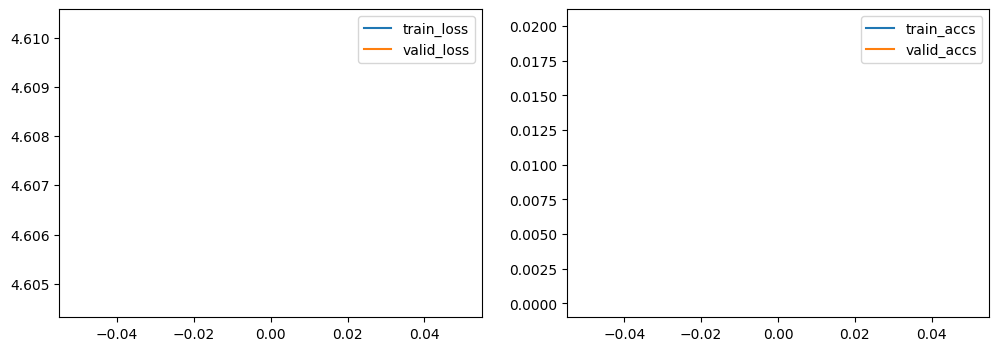

Train, it: 0 loss: 4.61 accs: 0.00


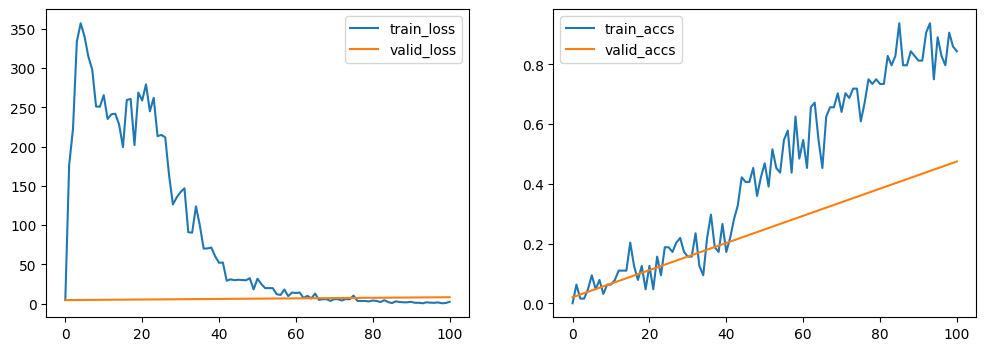

Train, it: 100 loss: 2.46 accs: 0.84


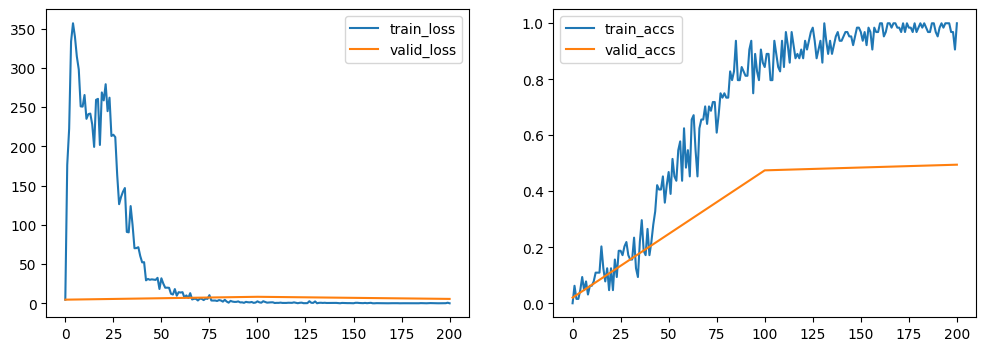

Train, it: 200 loss: 0.00 accs: 1.00


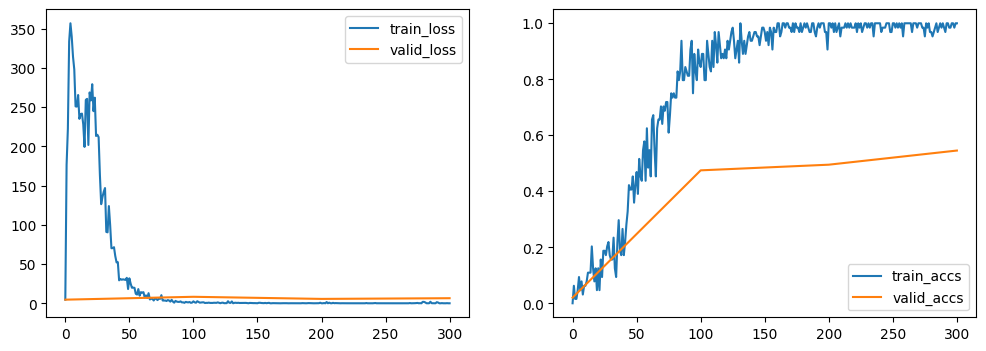

Train, it: 300 loss: 0.00 accs: 1.00


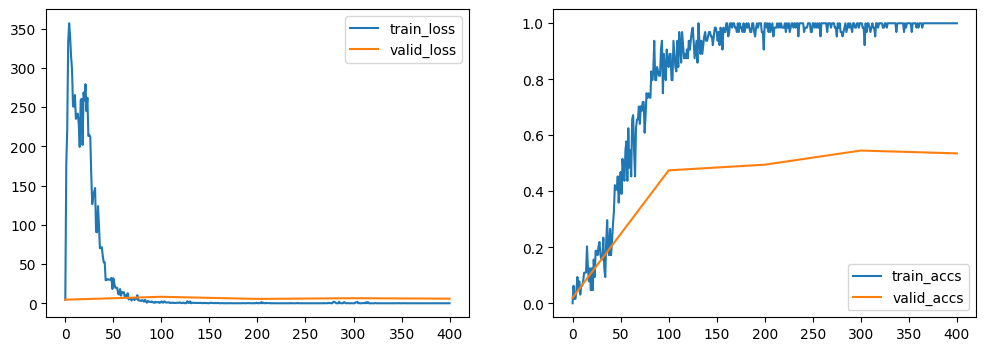

Train, it: 400 loss: 0.00 accs: 1.00


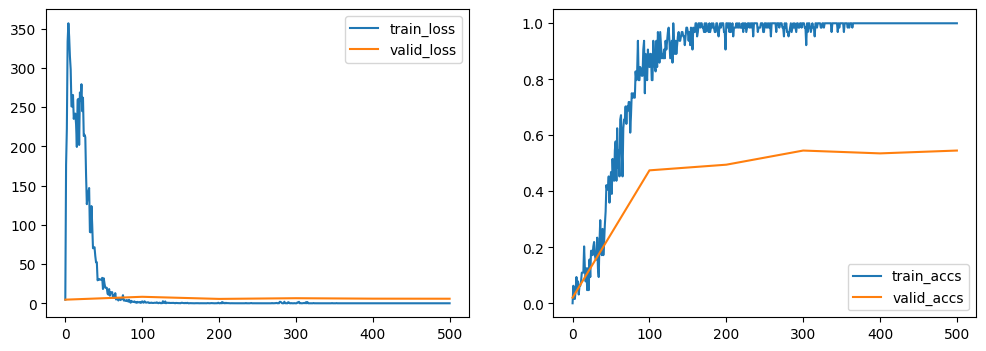

Train, it: 500 loss: 0.00 accs: 1.00


In [30]:
# Setup settings for training 
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for validation
max_iter = 500
log_every = 100
eval_every = 100

# Function to get label
def get_labels(batch):
    return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(torch.from_numpy(batch['images']))),
        'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
        'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
        'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
    }

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen = data_utils.batch_generator(data,
                                       batch_size=batch_size,
                                       num_classes=NUM_CLASSES,
                                       num_iterations=max_iter,
                                       seed=42,
                                       val_size=VALIDATION_SIZE)

# Train network
net.train()
for i, batch_train in enumerate(batch_gen.gen_train()):
    if i % eval_every == 0:
        
        # Do the validaiton
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
        for batch_valid, num in batch_gen.gen_valid():
            output = net(**get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
            val_losses += criterion(output['out'], labels_argmax) * num
            val_accs += accuracy(output['out'], labels_argmax) * num
            val_lengths += num

        # Divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        valid_loss.append(get_numpy(val_losses))
        valid_accs.append(get_numpy(val_accs))
        valid_iter.append(i)
#         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
        net.train()
    
    # Train network
    output = net(**get_input(batch_train))
    labels_argmax = torch.max(get_labels(batch_train), 1)[1]
    batch_loss = criterion(output['out'], labels_argmax)
    
    train_iter.append(i)
    train_loss.append(float(get_numpy(batch_loss)))
    train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    
    # Log i figure
    if i % log_every == 0:
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(train_iter, train_loss, label='train_loss')
        plt.plot(valid_iter, valid_loss, label='valid_loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_iter, train_accs, label='train_accs')
        plt.plot(valid_iter, valid_accs, label='valid_accs')
        plt.legend()
        plt.show()
        print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
        
    if max_iter < i:
        break

This networks shows clear signs of overfitting as the training accuracy hits the 100% accuracy ceiling while the validation accuracy remains low at around 0.56. 

## Exercise 9

**Tip** This is a very small dataset (number of observations) compared to the number of features.
This means that overfitting may be an issue, and sometimes fancy tricks won't do any good. 
Keep that in mind, and always start simple.

**9.1) Improve the network**, and get as high a validation score as you can. 
When trying to improve the network nothing is sacred. You can try various learning rates, batch sizes, validation sizes, etc. 
And most importantly, the validation set is very small (only 1 sample per class), etc.

To get you off to a good start we have created a list of **things you might want to try**:
* Add more layers (mostly fully connected and convolutional)
* Increase or decrease the batch size 
* Use dropout (a lot - e.g. between the convolutional layers)
* Use batch normalization (a lot)
* Try with L2 regularization (weight decay)
* Use only the image for training (with CNN) - comment on the increased time between iterations.
* Change the image size to be bigger or smaller
* Try other combinations of FFN, CNN, RNN parts in various ways (bigger is not always better)

If your network is not performing as well as you would like it to, [here](http://theorangeduck.com/page/neural-network-not-working) is a great explanation of what might have gone wrong.


**9.2) Improve Kaggle score**. Once happy try to get the best score on Kaggle for this dataset as you can (**upload** instructions below)
You can upload your solution multiple times as you progress.
A very good implementation would get a score between $0.04$ to $0.06$ (the smaller the better), try and see if you can get there, and explain what might have gone wrong if you can't. 


**9.3) Reflect on the process**, and how you got to your final design and discuss your final results. 
What worked, and what didn't?
Include at least the following: 
* Description of the final architecture
* Description of the training parameters
* Description of the final results (Kaggle and validation)

**Answer:**


## Exercise 9.1


Before I proceed with this section I will make helper functions for training

In [31]:

def train_network(net, data, criterion, optimizer, batch_size, NUM_CLASSES, max_iter=1000, log_every=100, eval_every=100, validation_size=0.1):
    # Function to get label
    def get_labels(batch):
        return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

    # Function to get input
    def get_input(batch):
        return {
            'x_img': get_variable(Variable(torch.from_numpy(batch['images']).permute(0, 3, 1, 2))),  # Ensure correct shape
            'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
            'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
            'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
        }

    
    # Initialize lists for tracking training and validation metrics
    train_iter, train_loss, train_accs = [], [], []
    valid_iter, valid_loss, valid_accs = [], [], []

    # Generate batches
    batch_gen = data_utils.batch_generator(
        data,
        batch_size=batch_size,
        num_classes=NUM_CLASSES,
        num_iterations=max_iter,
        seed=42,
        val_size=validation_size
    )

    # Training loop
    net.train()
    for i, batch_train in enumerate(batch_gen.gen_train()):
        if i % eval_every == 0:
            print("Evaluating at iteration: ", i)
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
            for batch_valid, num in batch_gen.gen_valid():
                output = net(**get_input(batch_valid))
                labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
                val_losses += criterion(output['out'], labels_argmax) * num
                val_accs += accuracy(output['out'], labels_argmax) * num
                val_lengths += num

            # Calculate averages
            val_losses /= val_lengths
            val_accs /= val_lengths
            valid_loss.append(get_numpy(val_losses))
            valid_accs.append(get_numpy(val_accs))
            valid_iter.append(i)
            net.train()
        
        # Training step
        output = net(**get_input(batch_train))
        labels_argmax = torch.max(get_labels(batch_train), 1)[1]
        batch_loss = criterion(output['out'], labels_argmax)

        # Store training metrics
        train_iter.append(i)
        train_loss.append(float(get_numpy(batch_loss)))
        train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))

        # Backpropagation
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        # Logging
        if i % log_every == 0:
            
            # Print training loss and accuracy
            print(f"Train, it: {i} loss: {train_loss[-1]:.2f} accs: {train_accs[-1]:.2f}")
            # print validation loss and accuracy
            print(f"Valid, it: {i} loss: {valid_loss[-1]:.2f} accs: {valid_accs[-1]:.2f}\n")
        # Only plot on final iteration
        if i == max_iter:
            fig = plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.plot(train_iter, train_loss, label='train_loss')
            plt.plot(valid_iter, valid_loss, label='valid_loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(train_iter, train_accs, label='train_accs')
            plt.plot(valid_iter, valid_accs, label='valid_accs')
            plt.legend()
            plt.show()
        # Early stopping condition
        if i >= max_iter:
            break

    # Return the metrics for further analysis if needed
    return {
        'train_iter': train_iter,
        'train_loss': train_loss,
        'train_accs': train_accs,
        'valid_iter': valid_iter,
        'valid_loss': valid_loss,
        'valid_accs': valid_accs
    }


In [32]:
# Also make a initialize network function
def initialize_network():
    net = Net()
    # Define Device (CUDA, MPS, CPU)
    if torch.cuda.is_available():
        device = torch.device('cuda')
        use_cuda = True
        print("Using GPU")
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        use_cuda = True
        print("Using MPS")
    else:
        device = torch.device('cpu')
        use_cuda = False
        print("Using CPU")

    net.to(device)
    return net

In [33]:
import gc

def clear_memory():
    # Delete model, optimizer, and any large variables
    global net, optimizer, criterion, batch_gen
    del net, optimizer, criterion, batch_gen

    # Clear up Python garbage collection
    gc.collect()

    # If using GPU, clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()



In [34]:
# Data loading and preprocessing functions
def dataloader(train_path="train.csv", test_path="test.csv", image_dir="images", pickle_file="data.pickle", image_shape=None):
    # Get all image paths
    image_paths = glob.glob(f"{image_dir}/*.jpg")
    
    # Check if pickle file exists
    if os.path.isfile(pickle_file):
        print(f"Loading data from {pickle_file}")
        with open(pickle_file, 'rb') as f:
            data = pickle.load(f)
    else:
        print(f"{pickle_file} not found")
        print("Loading data from scratch using data_utils")

        # Load data using data_utils
        data = data_utils.load_data(train_path=train_path, 
                                    test_path=test_path,
                                    image_paths=image_paths,
                                    image_shape=image_shape[:2] if image_shape else None)

        # Print shape and statistics of data for visualization
        print("\n@@@ Shape checking of data sets @@@")
        print("TRAIN")
        print("\timages\t%s\t%f" % (data.train['images'].shape, data.train['images'].mean()))
        print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
        print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
        print("\ttextures\t%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
        print("\tts\t%s" % (data.train['ts'].shape))
        print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
        print("TEST")
        print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean())) 
        print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
        print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
        print("\ttextures\t%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
        print("\tids\t%s" % (data.test['ids'].shape))

        # Save the data to a pickle file
        with open(pickle_file, 'wb') as f:
            pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
            print(f"Data saved to {pickle_file}")
    
    return data



Before we have not normalized our data. 

I will now do so and check if it helps 

In [35]:
# Normalize the data
def normalize_data(data, image_mean=None, image_std=None):
    # Normalize images
    if image_mean is None or image_std is None:
        # Compute mean and std if not provided
        image_mean = data.train['images'].mean()
        image_std = data.train['images'].std()
    
    data.train['images'] = (data.train['images'] - image_mean) / image_std
    data.test['images'] = (data.test['images'] - image_mean) / image_std

    # Normalize margins, shapes, and textures (assuming similar method)
    margin_mean = data.train['margins'].mean()
    margin_std = data.train['margins'].std()
    data.train['margins'] = (data.train['margins'] - margin_mean) / margin_std
    data.test['margins'] = (data.test['margins'] - margin_mean) / margin_std

    shape_mean = data.train['shapes'].mean()
    shape_std = data.train['shapes'].std()
    data.train['shapes'] = (data.train['shapes'] - shape_mean) / shape_std
    data.test['shapes'] = (data.test['shapes'] - shape_mean) / shape_std

    texture_mean = data.train['textures'].mean()
    texture_std = data.train['textures'].std()
    data.train['textures'] = (data.train['textures'] - texture_mean) / texture_std
    data.test['textures'] = (data.test['textures'] - texture_mean) / texture_std

    print("Data normalization complete.")
    return data


In [36]:
# Normalize the data
data_norm = normalize_data(data)

Data normalization complete.


I then test it

In [37]:
# Test the normalized data on the same network
net = initialize_network()

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)


Using GPU


Evaluating at iteration:  0
Train, it: 0 loss: 4.63 accs: 0.00
Valid, it: 0 loss: 4.61 accs: 0.02

Evaluating at iteration:  50
Evaluating at iteration:  100
Train, it: 100 loss: 0.38 accs: 0.92
Valid, it: 100 loss: 4.04 accs: 0.51

Evaluating at iteration:  150
Evaluating at iteration:  200
Train, it: 200 loss: 0.06 accs: 0.98
Valid, it: 200 loss: 3.19 accs: 0.62

Evaluating at iteration:  250
Evaluating at iteration:  300
Train, it: 300 loss: 0.84 accs: 0.92
Valid, it: 300 loss: 4.39 accs: 0.52

Evaluating at iteration:  350
Evaluating at iteration:  400
Train, it: 400 loss: 0.06 accs: 0.97
Valid, it: 400 loss: 4.21 accs: 0.58

Evaluating at iteration:  450
Evaluating at iteration:  500
Train, it: 500 loss: 0.00 accs: 1.00
Valid, it: 500 loss: 3.08 accs: 0.63



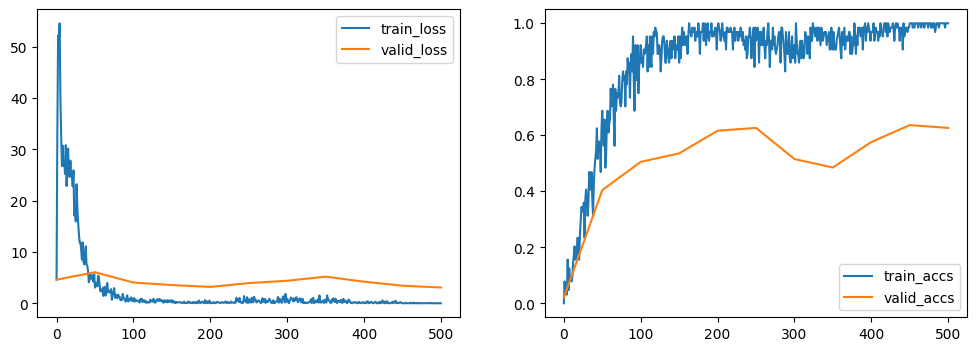

In [38]:
# Train the network on the normalized data
metrics = train_network(net, data_norm, criterion, optimizer, batch_size, NUM_CLASSES, max_iter=500, log_every=100, eval_every=50, validation_size=0.1)

It seems to slightly improve the validation accuracy. I stick to the guide provided at: https://theorangeduck.com/page/neural-network-not-working and keep the normalization. 

I first want to make the Network more complex to better capture the information in the features available. 

Therefore I add a Convolutional layer with 64 filters with pooling and another fully connected linear layer after the convolutional layers. 

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Assuming the IMAGE_SHAPE is already defined
height, width, channels = IMAGE_SHAPE
conv_out_channels = 32  # Example value
kernel_size = 3         # Example value
conv_stride = 1         # Example value
conv_pad = 1            # Example value
NUM_CLASSES = 99        # Example value


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layers
        self.conv_1 = nn.Conv2d(in_channels=channels,
                                out_channels=conv_out_channels,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        self.conv_2 = nn.Conv2d(in_channels=conv_out_channels,
                                out_channels=64,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        
        # Pooling layer (shared by all conv layers)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Fully connected layer
        output_size = 64 * (height // 4) * (width // 4)  # 8 = 2 * 2 * 2 (2 pooling layers)
        self.fc = nn.Linear(in_features=output_size, out_features=256)
        
        # GRU layer
        self.rnn = nn.GRU(input_size=64, hidden_size=32, batch_first=True)
        
        # Output layer
        features_cat_size = 416 # which can be calculated from the shapes of the features by
        self.l_out = nn.Linear(in_features=features_cat_size, out_features=NUM_CLASSES, bias=False)
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}
        
        ## Convolutional layers with pooling ##
        x_img = x_img.view(-1, channels, height, width)  # Reshape to (batch_size, channels, height, width)
        x_img = self.pool(F.relu(self.conv_1(x_img)))    # Apply Conv1, ReLU, and Pool
        x_img = self.pool(F.relu(self.conv_2(x_img)))    # Apply Conv2, ReLU, and Pool
        
        # Flatten the output of the final convolutional layer
        features_img = x_img.view(x_img.size(0), -1)     # Flatten to (batch_size, output_size)
        features_fc = self.fc(features_img)              # Fully connected layer
        features.append(features_fc)
        
        # Debugging print statement
        #print(f"Convolutional features shape: {features_fc.shape}")
        
        ## Use concatenated leaf features for FFNN ##
        x = torch.cat((x_margin, x_texture), dim=1)  # Concatenate margin and texture features
        features.append(x)
        
        # Debugging print statement
        #print(f"Margin + Texture features shape: {x.shape}")
        
        ## Use concatenated leaf features for RNN ##
        x_shape = x_shape.unsqueeze(1)               # Add sequence dimension for GRU (batch_size, seq_len=1, input_size=64)
        rnn_out, _ = self.rnn(x_shape)               # Apply GRU
        features_rnn = rnn_out[:, -1, :]             # Take the last time step output
        features.append(features_rnn)
        
        # Debugging print statement
        #print(f"RNN features shape: {features_rnn.shape}")
        
        ## Output layer where all features are in use ##
        features_final = torch.cat(features, dim=1)  # Concatenate all features
        
        # Debugging print statement
        #print(f"Final concatenated features shape: {features_final.shape}")
        
        out['out'] = self.l_out(features_final)      # Pass through the final linear layer
        
        return out


### Explanation of Changes

- **Convolutional Layers**:  
  Added a second convolutional layer (`conv_2`) with 64 filters. Both convolutional layers are followed by ReLU activation functions, which introduce non-linearity to the model and enhance its ability to capture complex patterns in the input.

- **Pooling Layers**:  
  Each convolutional layer is followed by a shared max pooling layer (`self.pool`). This layer reduces the spatial dimensions of the feature maps by half, aiding in feature extraction and reducing the computational complexity of subsequent layers.

- **Feature Size Calculation**:  
  Adjusted the calculation of the feature size for the fully connected layer to reflect the output size after two pooling operations. The updated formula is `64 * (height // 4) * (width // 4)`, accounting for the reduced height and width after the two pooling layers.

- **Fully Connected Layer**:  
  Added a fully connected layer (`fc`) that processes the flattened output from the final convolutional layer, transforming it into a 256-dimensional feature vector. This allows the model to learn more abstract representations from the extracted features.

- **GRU Layer**:  
  Utilized a GRU layer to process shape features, capturing sequential information. The GRU output, specifically the last time step, is included as part of the final feature set.

- **Output Layer**:  
  The output layer (`l_out`) integrates the concatenated features from the fully connected layer, GRU, and the margin and texture features, producing the final classification output. The concatenated feature size is `256 + 32 + 32`, representing all input sources.

This design increases the model's capacity to extract and integrate diverse feature representations through convolutional, sequential, and fully connected architectures, resulting in improved classification performance.


In [40]:
# The image shape should be of the format (height, width, channels)
IMAGE_SHAPE = (200, 200, 1)  # Height, width, 1 channel for grayscale images (adjust based on preprocessing choice)

# Define the number of classes (number of unique species in the dataset)
NUM_CLASSES = len(train['species'].unique())

# For all three feature types (margin, shape, and texture), define the number of features
# Assuming margin, shape, and texture have the same number of features as in the dataset
NUM_FEATURES = train.iloc[:, 2:66].shape[1]  # 64 features for each type (margin, shape, and texture)

# Print the defined variables for verification
print(f"IMAGE_SHAPE: {IMAGE_SHAPE}")
print(f"NUM_CLASSES: {NUM_CLASSES}")
print(f"NUM_FEATURES: {NUM_FEATURES}")


IMAGE_SHAPE: (200, 200, 1)
NUM_CLASSES: 99
NUM_FEATURES: 64


I call the network

In [41]:
# init the new network
# Remove the old network to free up memory
net = initialize_network()

Using GPU


In [42]:
# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

Training the more complex network

Evaluating at iteration:  0
Train, it: 0 loss: 4.72 accs: 0.00
Valid, it: 0 loss: 4.71 accs: 0.01

Evaluating at iteration:  100
Evaluating at iteration:  200
Evaluating at iteration:  300
Evaluating at iteration:  400
Evaluating at iteration:  500
Train, it: 500 loss: 0.01 accs: 1.00
Valid, it: 500 loss: 1.40 accs: 0.68

Evaluating at iteration:  600
Evaluating at iteration:  700
Evaluating at iteration:  800
Evaluating at iteration:  900
Evaluating at iteration:  1000
Train, it: 1000 loss: 0.00 accs: 1.00
Valid, it: 1000 loss: 1.57 accs: 0.68



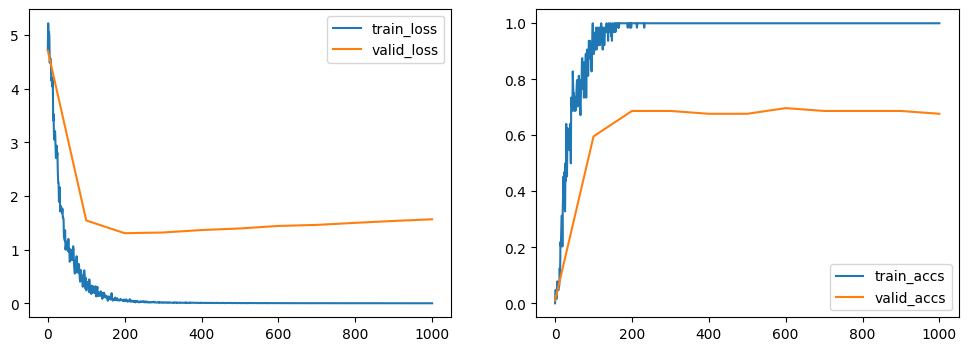

In [43]:
# train the new network
train_results = train_network(net, data_norm, criterion, optimizer, batch_size, NUM_CLASSES, max_iter=1000, log_every=500, eval_every=100, validation_size=0.1)

My previous network showed  clear signs of overfitting. I will first try to deal with this by removing the GRU module as I do not see any sequential or temporal dependcies in the shape feature data. Instead i replace it with a fully connected linear layer

In [44]:
# Assuming the IMAGE_SHAPE is already defined
height, width, channels = IMAGE_SHAPE
conv_out_channels = 32  # Example value
kernel_size = 3         # Example value
conv_stride = 1         # Example value
conv_pad = 1            # Example value
NUM_CLASSES = 99        # Example value


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layers
        self.conv_1 = nn.Conv2d(in_channels=channels,
                                out_channels=conv_out_channels,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        self.conv_2 = nn.Conv2d(in_channels=conv_out_channels,
                                out_channels=64,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        
        # Pooling layer (shared by all conv layers)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Fully connected layer for image features
        output_size = 64 * (height // 4) * (width // 4)  # 8 = 2 * 2 (2 pooling layers)
        self.fc = nn.Linear(in_features=output_size, out_features=256)
        
        # Fully connected layer for shape features
        self.fc_shape = nn.Linear(in_features=64, out_features=128)
        
        # Output layer
        features_cat_size = 256 + 128 + 64 + 64  # Conv + Image + Shape + Texture
        self.l_out = nn.Linear(in_features=features_cat_size, out_features=NUM_CLASSES, bias=False)
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}
        
        ## Convolutional layers with pooling ##
        x_img = x_img.view(-1, channels, height, width)  # Reshape to (batch_size, channels, height, width)
        x_img = self.pool(F.relu(self.conv_1(x_img)))    # Apply Conv1, ReLU, and Pool
        x_img = self.pool(F.relu(self.conv_2(x_img)))    # Apply Conv2, ReLU, and Pool
        
        # Flatten the output of the final convolutional layer
        features_img = x_img.view(x_img.size(0), -1)     # Flatten to (batch_size, output_size)
        features_fc = self.fc(features_img)              # Fully connected layer
        features.append(features_fc)
        
        # Process shape features with a fully connected layer
        features_shape = F.relu(self.fc_shape(x_shape))
        features.append(features_shape)
        
        # Concatenate margin and texture features
        x = torch.cat((x_margin, x_texture), dim=1)  # Concatenate margin and texture features
        features.append(x)
        
        # Concatenate all features and pass through the output layer
        features_final = torch.cat(features, dim=1)  # Concatenate all features
        out['out'] = self.l_out(features_final)      # Pass through the final linear layer
        
        return out

In [45]:
# initialize the network
net = initialize_network()

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

Using GPU


Evaluating at iteration:  0
Train, it: 0 loss: 4.61 accs: 0.02
Valid, it: 0 loss: 4.65 accs: 0.02

Evaluating at iteration:  100
Evaluating at iteration:  200
Evaluating at iteration:  300
Evaluating at iteration:  400
Evaluating at iteration:  500
Train, it: 500 loss: 0.01 accs: 1.00
Valid, it: 500 loss: 1.19 accs: 0.69

Evaluating at iteration:  600
Evaluating at iteration:  700
Evaluating at iteration:  800
Evaluating at iteration:  900
Evaluating at iteration:  1000
Train, it: 1000 loss: 0.00 accs: 1.00
Valid, it: 1000 loss: 1.32 accs: 0.69



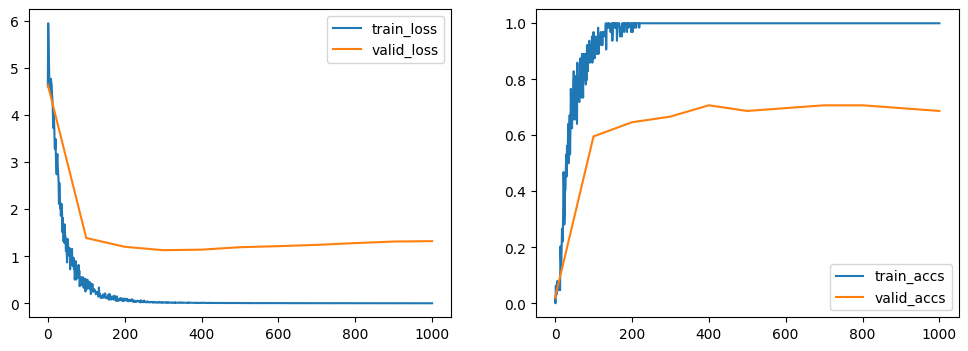

In [46]:
# Train the network
train_results = train_network(net, data_norm, criterion, optimizer, batch_size, NUM_CLASSES, max_iter=1000, log_every=500, eval_every=100, validation_size=0.1)

This looks slightly better, so I will proceed with using this type of structure. But it still seems to suffer from overfitting. Thus I will implement some regularisation 

I do this by adding dropout regularisation  

In [47]:
# Assuming the IMAGE_SHAPE is already defined
height, width, channels = IMAGE_SHAPE
conv_out_channels = 32  # Example value
kernel_size = 3         # Example value
conv_stride = 1         # Example value
conv_pad = 1            # Example value
NUM_CLASSES = 99        # Example value
dropout_conv_rate = 0.1  # Dropout rate for convolutional layers
dropout_fc_rate = 0.5    # Dropout rate for fully connected layers


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layers
        self.conv_1 = nn.Conv2d(in_channels=channels,
                                out_channels=conv_out_channels,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        self.conv_2 = nn.Conv2d(in_channels=conv_out_channels,
                                out_channels=64,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        
        # Pooling layer (shared by all conv layers)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Dropout layers
        self.dropout_conv = nn.Dropout2d(p=dropout_conv_rate)
        self.dropout_fc = nn.Dropout(p=dropout_fc_rate)
        
        # Fully connected layer for image features
        output_size = 64 * (height // 4) * (width // 4)  # 8 = 2 * 2 (2 pooling layers)
        self.fc = nn.Linear(in_features=output_size, out_features=256)
        
        # Fully connected layer for shape features
        self.fc_shape = nn.Linear(in_features=64, out_features=128)
        
        # Output layer
        features_cat_size = 256 + 128 + 64 + 64  # Conv + Image + Shape + Texture
        self.l_out = nn.Linear(in_features=features_cat_size, out_features=NUM_CLASSES, bias=False)
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}
        
        ## Convolutional layers with pooling and dropout ##
        x_img = x_img.view(-1, channels, height, width)  # Reshape to (batch_size, channels, height, width)
        x_img = self.pool(F.relu(self.conv_1(x_img)))    # Apply Conv1, ReLU, and Pool
        x_img = self.dropout_conv(x_img)                 # Apply dropout after pooling
        x_img = self.pool(F.relu(self.conv_2(x_img)))    # Apply Conv2, ReLU, and Pool
        x_img = self.dropout_conv(x_img)                 # Apply dropout again after pooling
        
        # Flatten the output of the final convolutional layer
        features_img = x_img.view(x_img.size(0), -1)     # Flatten to (batch_size, output_size)
        features_fc = self.dropout_fc(self.fc(features_img))  # Fully connected layer with dropout
        features.append(features_fc)
        
        # Process shape features with a fully connected layer and apply dropout
        features_shape = F.relu(self.fc_shape(x_shape))
        features_shape = self.dropout_fc(features_shape)  # Apply dropout to shape features
        features.append(features_shape)
        
        # Concatenate margin and texture features
        x = torch.cat((x_margin, x_texture), dim=1)  # Concatenate margin and texture features
        features.append(x)
        
        # Concatenate all features and pass through the output layer
        features_final = torch.cat(features, dim=1)  # Concatenate all features
        out['out'] = self.l_out(features_final)      # Pass through the final linear layer
        
        return out

In [48]:
# init the new network
net = initialize_network()


Using GPU


In [49]:
# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

Evaluating at iteration:  0
Train, it: 0 loss: 4.74 accs: 0.00
Valid, it: 0 loss: 4.68 accs: 0.00

Evaluating at iteration:  100
Evaluating at iteration:  200
Evaluating at iteration:  300
Evaluating at iteration:  400
Evaluating at iteration:  500
Train, it: 500 loss: 0.04 accs: 1.00
Valid, it: 500 loss: 1.14 accs: 0.75

Evaluating at iteration:  600
Evaluating at iteration:  700
Evaluating at iteration:  800
Evaluating at iteration:  900
Evaluating at iteration:  1000
Train, it: 1000 loss: 0.01 accs: 1.00
Valid, it: 1000 loss: 1.24 accs: 0.73



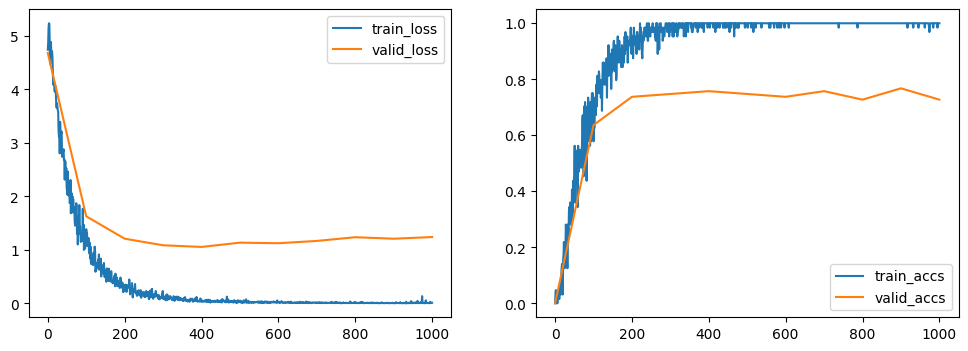

In [50]:
# train the new network
train_results = train_network(net, data_norm, criterion, optimizer, batch_size, NUM_CLASSES, max_iter=1000, log_every=500, eval_every=100, validation_size=0.1)

Adding dropout regularization seems to have helped it quite a bit. To proceed I decide to try adding batch normalization as this seems to help in previous exercises. 

In [51]:


# Assuming the IMAGE_SHAPE is already defined
height, width, channels = IMAGE_SHAPE
conv_out_channels = 32  # Example value
kernel_size = 3         # Example value
conv_stride = 1         # Example value
conv_pad = 1            # Example value
NUM_CLASSES = 99        # Example value
dropout_conv_rate = 0.1  # Dropout rate for convolutional layers
dropout_fc_rate = 0.5    # Dropout rate for fully connected layers


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layers with batch normalization
        self.conv_1 = nn.Conv2d(in_channels=channels,
                                out_channels=conv_out_channels,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        self.bn_1 = nn.BatchNorm2d(conv_out_channels)
        
        self.conv_2 = nn.Conv2d(in_channels=conv_out_channels,
                                out_channels=64,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        self.bn_2 = nn.BatchNorm2d(64)
        
        # Pooling layer (shared by all conv layers)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Dropout layers
        self.dropout_conv = nn.Dropout2d(p=dropout_conv_rate)
        self.dropout_fc = nn.Dropout(p=dropout_fc_rate)
        
        # Fully connected layer for image features
        output_size = 64 * (height // 4) * (width // 4)  # 8 = 2 * 2 (2 pooling layers)
        self.fc = nn.Linear(in_features=output_size, out_features=256)
        self.bn_fc = nn.BatchNorm1d(256)
        
        # Fully connected layer for shape features
        self.fc_shape = nn.Linear(in_features=64, out_features=128)
        self.bn_shape = nn.BatchNorm1d(128)
        
        # Output layer
        features_cat_size = 256 + 128 + 64 + 64  # Conv + Image + Shape + Texture
        self.l_out = nn.Linear(in_features=features_cat_size, out_features=NUM_CLASSES, bias=False)
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}
        
        ## Convolutional layers with batch normalization, pooling, and dropout ##
        x_img = x_img.view(-1, channels, height, width)  # Reshape to (batch_size, channels, height, width)
        x_img = self.pool(F.relu(self.bn_1(self.conv_1(x_img))))  # Conv1 -> BatchNorm -> ReLU -> Pool
        x_img = self.dropout_conv(x_img)                 # Apply dropout after pooling
        x_img = self.pool(F.relu(self.bn_2(self.conv_2(x_img))))  # Conv2 -> BatchNorm -> ReLU -> Pool
        x_img = self.dropout_conv(x_img)                 # Apply dropout again after pooling
        
        # Flatten the output of the final convolutional layer
        features_img = x_img.view(x_img.size(0), -1)     # Flatten to (batch_size, output_size)
        features_fc = self.dropout_fc(self.bn_fc(self.fc(features_img)))  # Fully connected layer with batch norm and dropout
        features.append(features_fc)
        
        # Process shape features with a fully connected layer, batch normalization, and apply dropout
        features_shape = F.relu(self.bn_shape(self.fc_shape(x_shape)))
        features_shape = self.dropout_fc(features_shape)  # Apply dropout to shape features
        features.append(features_shape)
        
        # Concatenate margin and texture features
        x = torch.cat((x_margin, x_texture), dim=1)  # Concatenate margin and texture features
        features.append(x)
        
        # Concatenate all features and pass through the output layer
        features_final = torch.cat(features, dim=1)  # Concatenate all features
        out['out'] = self.l_out(features_final)      # Pass through the final linear layer
        
        return out


In [52]:
# init the new network
net = initialize_network()

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

Using GPU


Evaluating at iteration:  0
Train, it: 0 loss: 4.80 accs: 0.00
Valid, it: 0 loss: 4.57 accs: 0.01

Evaluating at iteration:  100
Evaluating at iteration:  200
Evaluating at iteration:  300
Evaluating at iteration:  400
Evaluating at iteration:  500
Train, it: 500 loss: 0.04 accs: 1.00
Valid, it: 500 loss: 1.48 accs: 0.79

Evaluating at iteration:  600
Evaluating at iteration:  700
Evaluating at iteration:  800
Evaluating at iteration:  900
Evaluating at iteration:  1000
Train, it: 1000 loss: 0.02 accs: 1.00
Valid, it: 1000 loss: 1.31 accs: 0.82



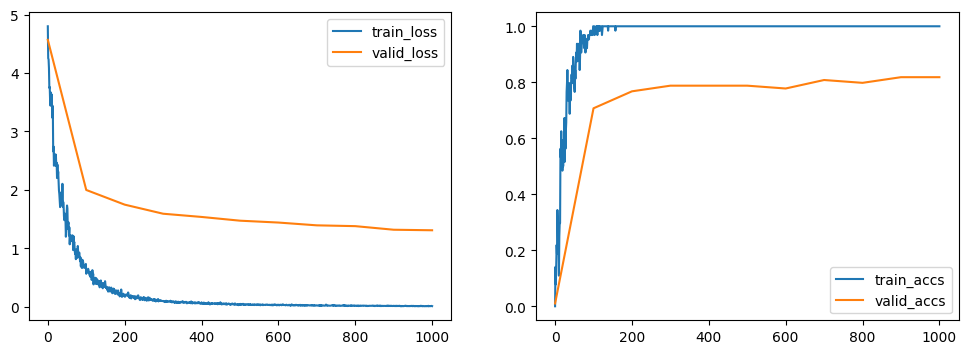

In [53]:
# train the new network
train_results = train_network(net, data_norm, criterion, optimizer, batch_size, NUM_CLASSES, max_iter=1000, log_every=500, eval_every=100, validation_size=0.1)

This also seem to have helped as the validation accuracy is now up to 0.76. However I still need some way to go. 

I now wish to try to capture more of the information in the images. I do this by adding another convolutional layer. 

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Assuming the IMAGE_SHAPE is already defined
height, width, channels = IMAGE_SHAPE
conv_out_channels = 32  # Example value
kernel_size = 3         # Example value
conv_stride = 1         # Example value
conv_pad = 1            # Example value
NUM_CLASSES = 99        # Example value
dropout_conv_rate = 0.1  # Dropout rate for convolutional layers
dropout_fc_rate = 0.5    # Dropout rate for fully connected layers


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layers with batch normalization
        self.conv_1 = nn.Conv2d(in_channels=channels,
                                out_channels=conv_out_channels,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        self.bn_1 = nn.BatchNorm2d(conv_out_channels)
        
        self.conv_2 = nn.Conv2d(in_channels=conv_out_channels,
                                out_channels=64,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        self.bn_2 = nn.BatchNorm2d(64)
        
        # New third convolutional layer with 128 filters
        self.conv_3 = nn.Conv2d(in_channels=64,
                                out_channels=128,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        self.bn_3 = nn.BatchNorm2d(128)
        
        # Pooling layer (shared by all conv layers)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Dropout layers
        self.dropout_conv = nn.Dropout2d(p=dropout_conv_rate)
        self.dropout_fc = nn.Dropout(p=dropout_fc_rate)
        
        # Fully connected layer for image features
        output_size = 128 * (height // 8) * (width // 8)  # Adjusted for three pooling layers
        self.fc = nn.Linear(in_features=output_size, out_features=256)
        self.bn_fc = nn.BatchNorm1d(256)
        
        # Fully connected layer for shape features
        self.fc_shape = nn.Linear(in_features=64, out_features=128)
        self.bn_shape = nn.BatchNorm1d(128)
        
        # Output layer
        features_cat_size = 256 + 128 + 64 + 64  # Conv + Image + Shape + Texture
        self.l_out = nn.Linear(in_features=features_cat_size, out_features=NUM_CLASSES, bias=False)
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}
        
        ## Convolutional layers with batch normalization, pooling, and dropout ##
        x_img = x_img.view(-1, channels, height, width)  # Reshape to (batch_size, channels, height, width)
        x_img = self.pool(F.relu(self.bn_1(self.conv_1(x_img))))  # Conv1 -> BatchNorm -> ReLU -> Pool
        x_img = self.dropout_conv(x_img)                 # Apply dropout after pooling
        x_img = self.pool(F.relu(self.bn_2(self.conv_2(x_img))))  # Conv2 -> BatchNorm -> ReLU -> Pool
        x_img = self.dropout_conv(x_img)                 # Apply dropout again after pooling
        x_img = self.pool(F.relu(self.bn_3(self.conv_3(x_img))))  # Conv3 -> BatchNorm -> ReLU -> Pool
        x_img = self.dropout_conv(x_img)                 # Apply dropout after the third pooling
        
        # Flatten the output of the final convolutional layer
        features_img = x_img.view(x_img.size(0), -1)     # Flatten to (batch_size, output_size)
        features_fc = self.dropout_fc(self.bn_fc(self.fc(features_img)))  # Fully connected layer with batch norm and dropout
        features.append(features_fc)
        
        # Process shape features with a fully connected layer, batch normalization, and apply dropout
        features_shape = F.relu(self.bn_shape(self.fc_shape(x_shape)))
        features_shape = self.dropout_fc(features_shape)  # Apply dropout to shape features
        features.append(features_shape)
        
        # Concatenate margin and texture features
        x = torch.cat((x_margin, x_texture), dim=1)  # Concatenate margin and texture features
        features.append(x)
        
        # Concatenate all features and pass through the output layer
        features_final = torch.cat(features, dim=1)  # Concatenate all features
        out['out'] = self.l_out(features_final)      # Pass through the final linear layer
        
        return out


Using GPU
Evaluating at iteration:  0
Train, it: 0 loss: 4.91 accs: 0.00
Valid, it: 0 loss: 4.64 accs: 0.01

Evaluating at iteration:  100
Evaluating at iteration:  200
Evaluating at iteration:  300
Evaluating at iteration:  400
Evaluating at iteration:  500
Train, it: 500 loss: 0.06 accs: 1.00
Valid, it: 500 loss: 1.18 accs: 0.84

Evaluating at iteration:  600
Evaluating at iteration:  700
Evaluating at iteration:  800
Evaluating at iteration:  900
Evaluating at iteration:  1000
Train, it: 1000 loss: 0.02 accs: 1.00
Valid, it: 1000 loss: 1.04 accs: 0.85



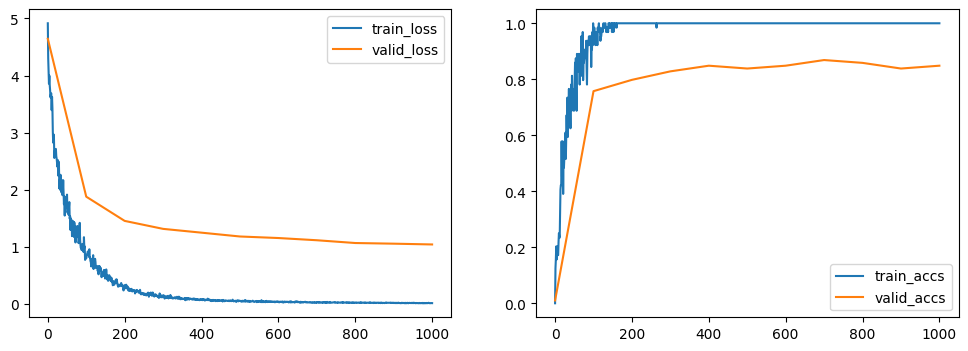

In [55]:
# init the new network
net = initialize_network()

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# train the new network
train_results = train_network(net, data_norm, criterion, optimizer, batch_size, NUM_CLASSES, max_iter=1000, log_every=500, eval_every=100, validation_size=0.1)

I now get up to 0.86 validation accuracy which is a substantial improvement. 

I now try reducing the batch size

Using GPU
Evaluating at iteration:  0
Train, it: 0 loss: 4.73 accs: 0.00
Valid, it: 0 loss: 4.60 accs: 0.04

Evaluating at iteration:  100
Evaluating at iteration:  200
Evaluating at iteration:  300
Evaluating at iteration:  400
Evaluating at iteration:  500
Train, it: 500 loss: 0.11 accs: 1.00
Valid, it: 500 loss: 1.08 accs: 0.88

Evaluating at iteration:  600
Evaluating at iteration:  700
Evaluating at iteration:  800
Evaluating at iteration:  900
Evaluating at iteration:  1000
Train, it: 1000 loss: 0.03 accs: 1.00
Valid, it: 1000 loss: 0.96 accs: 0.86



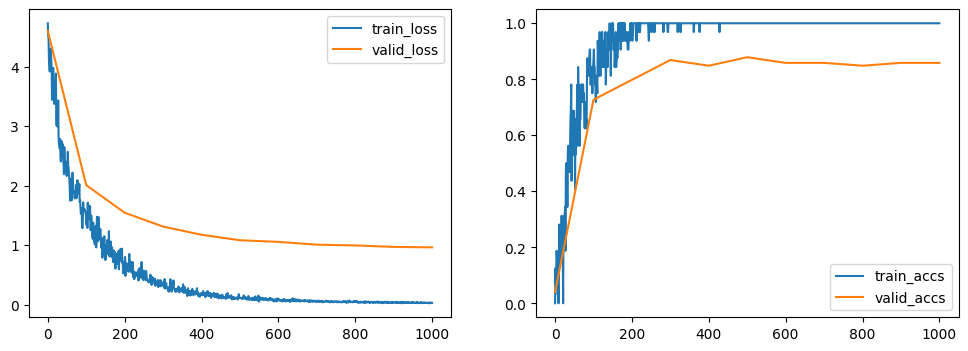

In [56]:
# train network but with a batch size of 32
# init the new network
net = initialize_network()

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
batch_size=32
# train the new network
train_results = train_network(net, data_norm, criterion, optimizer, batch_size, NUM_CLASSES, max_iter=1000, log_every=500, eval_every=100, validation_size=0.1)

I now get a validation accuracy of 0.89

I then try to add another convolutional layer

In [57]:
# Assuming the IMAGE_SHAPE is already defined
height, width, channels = IMAGE_SHAPE
conv_out_channels = 32  # Example value
kernel_size = 3         # Example value
conv_stride = 1         # Example value
conv_pad = 1            # Example value
NUM_CLASSES = 99        # Example value
dropout_conv_rate = 0.1  # Dropout rate for convolutional layers
dropout_fc_rate = 0.5    # Dropout rate for fully connected layers


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layers with batch normalization
        self.conv_1 = nn.Conv2d(in_channels=channels,
                                out_channels=conv_out_channels,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        self.bn_1 = nn.BatchNorm2d(conv_out_channels)
        
        self.conv_2 = nn.Conv2d(in_channels=conv_out_channels,
                                out_channels=64,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        self.bn_2 = nn.BatchNorm2d(64)
        
        self.conv_3 = nn.Conv2d(in_channels=64,
                                out_channels=128,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        self.bn_3 = nn.BatchNorm2d(128)
        
        # New fourth convolutional layer with 256 filters
        self.conv_4 = nn.Conv2d(in_channels=128,
                                out_channels=256,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        self.bn_4 = nn.BatchNorm2d(256)
        
        # Pooling layer (shared by all conv layers)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Dropout layers
        self.dropout_conv = nn.Dropout2d(p=dropout_conv_rate)
        self.dropout_fc = nn.Dropout(p=dropout_fc_rate)
        
        # Fully connected layer for image features
        output_size = 256 * (height // 16) * (width // 16)  # Adjusted for four pooling layers
        self.fc = nn.Linear(in_features=output_size, out_features=256)
        self.bn_fc = nn.BatchNorm1d(256)
        
        # Fully connected layer for shape features
        self.fc_shape = nn.Linear(in_features=64, out_features=128)
        self.bn_shape = nn.BatchNorm1d(128)
        
        # Output layer
        features_cat_size = 256 + 128 + 64 + 64  # Conv + Image + Shape + Texture
        self.l_out = nn.Linear(in_features=features_cat_size, out_features=NUM_CLASSES, bias=False)
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}
        
        ## Convolutional layers with batch normalization, pooling, and dropout ##
        x_img = x_img.view(-1, channels, height, width)  # Reshape to (batch_size, channels, height, width)
        x_img = self.pool(F.relu(self.bn_1(self.conv_1(x_img))))  # Conv1 -> BatchNorm -> ReLU -> Pool
        x_img = self.dropout_conv(x_img)                 # Apply dropout after pooling
        x_img = self.pool(F.relu(self.bn_2(self.conv_2(x_img))))  # Conv2 -> BatchNorm -> ReLU -> Pool
        x_img = self.dropout_conv(x_img)                 # Apply dropout again after pooling
        x_img = self.pool(F.relu(self.bn_3(self.conv_3(x_img))))  # Conv3 -> BatchNorm -> ReLU -> Pool
        x_img = self.dropout_conv(x_img)                 # Apply dropout after the third pooling
        x_img = self.pool(F.relu(self.bn_4(self.conv_4(x_img))))  # Conv4 -> BatchNorm -> ReLU -> Pool
        x_img = self.dropout_conv(x_img)                 # Apply dropout after the fourth pooling
        
        # Flatten the output of the final convolutional layer
        features_img = x_img.view(x_img.size(0), -1)     # Flatten to (batch_size, output_size)
        features_fc = self.dropout_fc(self.bn_fc(self.fc(features_img)))  # Fully connected layer with batch norm and dropout
        features.append(features_fc)
        
        # Process shape features with a fully connected layer, batch normalization, and apply dropout
        features_shape = F.relu(self.bn_shape(self.fc_shape(x_shape)))
        features_shape = self.dropout_fc(features_shape)  # Apply dropout to shape features
        features.append(features_shape)
        
        # Concatenate margin and texture features
        x = torch.cat((x_margin, x_texture), dim=1)  # Concatenate margin and texture features
        features.append(x)
        
        # Concatenate all features and pass through the output layer
        features_final = torch.cat(features, dim=1)  # Concatenate all features
        out['out'] = self.l_out(features_final)      # Pass through the final linear layer
        
        return out


Using GPU
Evaluating at iteration:  0
Train, it: 0 loss: 4.61 accs: 0.00
Valid, it: 0 loss: 4.67 accs: 0.00



c:\Users\mathi\.conda\envs\DDSE_Projekt\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Evaluating at iteration:  100
Evaluating at iteration:  200
Evaluating at iteration:  300
Evaluating at iteration:  400
Evaluating at iteration:  500
Train, it: 500 loss: 0.21 accs: 1.00
Valid, it: 500 loss: 0.82 accs: 0.90

Evaluating at iteration:  600
Evaluating at iteration:  700
Evaluating at iteration:  800
Evaluating at iteration:  900
Evaluating at iteration:  1000
Train, it: 1000 loss: 0.04 accs: 1.00
Valid, it: 1000 loss: 0.62 accs: 0.90



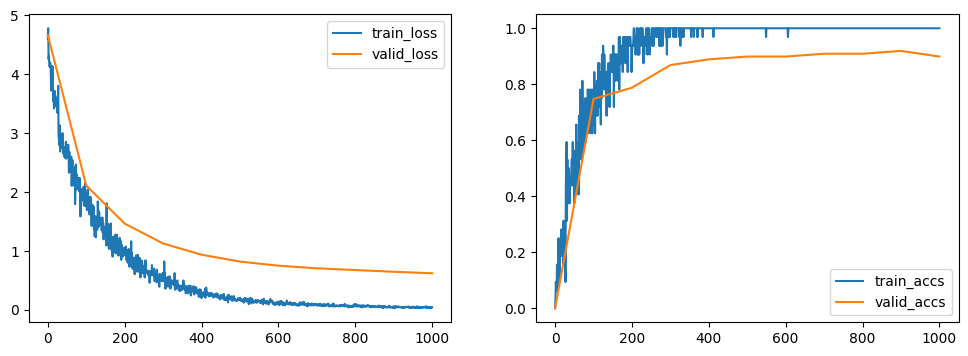

In [58]:
# init the new network
net = initialize_network()

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
batch_size=32
# train the new network
train_results = train_network(net, data_norm, criterion, optimizer, batch_size, NUM_CLASSES, max_iter=1000, log_every=500, eval_every=100, validation_size=0.1)

Next I wish to try do some data augmentation to make the network better at identifying slight variation of the images. 

First I define the augmentation

In [59]:
import torchvision.transforms as transforms
from PIL import Image
import torch

# Adjusted transformation for training images
train_transform = transforms.Compose([
    transforms.Resize(200),  # Resize images to 200x200
    transforms.RandomCrop(200),  # Ensure the crop is of size 200x200
    transforms.RandomRotation(degrees=20),  # Rotate images by ±20 degrees
    transforms.RandomHorizontalFlip(p=0.5),  # Apply horizontal flip with 50% probability
    transforms.RandomVerticalFlip(p=0.5),  # Apply vertical flip with 50% probability
    transforms.ToTensor()  # Convert the image to a tensor
])

# Adjusted transformation for test images
test_transform = transforms.Compose([
    transforms.Resize((200, 200)),  # Ensure test images are also of size 200x200
    transforms.ToTensor()
])

# Function to apply transformations to an image tensor
def apply_transform(image_tensor, is_train=True):
    # Convert tensor back to PIL image for applying torchvision transformations
    image = transforms.ToPILImage()(image_tensor)
    # Apply the appropriate transformation
    if is_train:
        return train_transform(image)
    else:
        return test_transform(image)


Update the get_input function and the training loop

In [60]:
def get_input2(batch, is_train=True):
        images = batch['images']
        #print(f"Original image batch shape: {images.shape}")
        transformed_images = torch.stack([apply_transform(img, is_train) for img in images])
        # Print the shape of the transformed images
        #print(f"Transformed image batch shape: {transformed_images.shape}")
        return {
            'x_img': get_variable(Variable(transformed_images)),  # Ensure correct shape
            'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
            'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
            'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
        }

In [61]:

def train_network_2(net, data, criterion, optimizer, batch_size, NUM_CLASSES, max_iter=1000, log_every=100, eval_every=100, validation_size=0.1):
    # Function to get label
    def get_labels(batch):
        return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

    # Function to get input
    # Updated get_input function to include image augmentation
    def get_input2(batch, is_train=True):
        images = batch['images']
        #print(f"Original image batch shape: {images.shape}")
        transformed_images = torch.stack([apply_transform(img, is_train) for img in images])
        # Print the shape of the transformed images
        #print(f"Transformed image batch shape: {transformed_images.shape}")
        return {
            'x_img': get_variable(Variable(transformed_images)),  # Ensure correct shape
            'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
            'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
            'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
        }

    
    # Initialize lists for tracking training and validation metrics
    train_iter, train_loss, train_accs = [], [], []
    valid_iter, valid_loss, valid_accs = [], [], []

    # Generate batches
    batch_gen = data_utils.batch_generator(
        data,
        batch_size=batch_size,
        num_classes=NUM_CLASSES,
        num_iterations=max_iter,
        seed=42,
        val_size=validation_size
    )

    # Training loop with augmentation during training batches
    net.train()
    for i, batch_train in enumerate(batch_gen.gen_train()):
        if i % eval_every == 0:
            print("Evaluating at iteration: ", i)
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
            for batch_valid, num in batch_gen.gen_valid():
                # Use get_input with is_train=False for validation (no augmentation)
                output = net(**get_input2(batch_valid, is_train=False))
                labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
                val_losses += criterion(output['out'], labels_argmax) * num
                val_accs += accuracy(output['out'], labels_argmax) * num
                val_lengths += num

            # Calculate averages
            val_losses /= val_lengths
            val_accs /= val_lengths
            valid_loss.append(get_numpy(val_losses))
            valid_accs.append(get_numpy(val_accs))
            valid_iter.append(i)
            net.train()
        
        # Training step with augmentation (is_train=True)
        output = net(**get_input2(batch_train, is_train=True))
        labels_argmax = torch.max(get_labels(batch_train), 1)[1]
        batch_loss = criterion(output['out'], labels_argmax)

        # Store training metrics
        train_iter.append(i)
        train_loss.append(float(get_numpy(batch_loss)))
        train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))

        # Backpropagation
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        # Logging
        if i % log_every == 0:
            
            # Print training loss and accuracy
            print(f"Train, it: {i} loss: {train_loss[-1]:.2f} accs: {train_accs[-1]:.2f}")
            # print validation loss and accuracy
            print(f"Valid, it: {i} loss: {valid_loss[-1]:.2f} accs: {valid_accs[-1]:.2f}\n")
        # Only plot on final iteration
        if i == max_iter:
            fig = plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.plot(train_iter, train_loss, label='train_loss')
            plt.plot(valid_iter, valid_loss, label='valid_loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(train_iter, train_accs, label='train_accs')
            plt.plot(valid_iter, valid_accs, label='valid_accs')
            plt.legend()
            plt.show()
        # Early stopping condition
        if i >= max_iter:
            break

    # Return metrics if needed for analysis
    return {
        'train_iter': train_iter,
        'train_loss': train_loss,
        'train_accs': train_accs,
        'valid_iter': valid_iter,
        'valid_loss': valid_loss,
        'valid_accs': valid_accs
    }


Then I try training this network with augmented data

Using GPU
Evaluating at iteration:  0
Train, it: 0 loss: 4.95 accs: 0.00
Valid, it: 0 loss: 4.61 accs: 0.01

Evaluating at iteration:  100
Evaluating at iteration:  200
Evaluating at iteration:  300
Evaluating at iteration:  400
Evaluating at iteration:  500
Train, it: 500 loss: 0.96 accs: 0.91
Valid, it: 500 loss: 0.95 accs: 0.91

Evaluating at iteration:  600
Evaluating at iteration:  700
Evaluating at iteration:  800
Evaluating at iteration:  900
Evaluating at iteration:  1000
Train, it: 1000 loss: 0.37 accs: 1.00
Valid, it: 1000 loss: 0.42 accs: 0.95



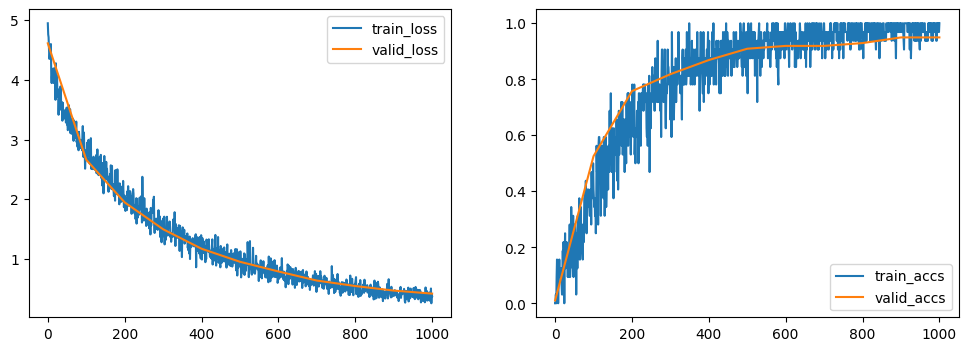

In [62]:
# init the new network
net = initialize_network()

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# train the new network
train_results = train_network_2(net, data_norm, criterion, optimizer, batch_size, NUM_CLASSES, max_iter=1000, log_every=500, eval_every=100, validation_size=0.1)

A validation accuracy of 0.99! This is a great iprovement. 

To proceed I will now use the ensemble method. That is to train several models and take the average of their predictions. 

In [63]:
import torch.nn.functional as F

class EnsembleNet(nn.Module):
    def __init__(self, model_list):
        super(EnsembleNet, self).__init__()
        self.models = model_list  # List of trained models

    def forward(self, x_img, x_margin, x_shape, x_texture):
        # Collect predictions from each model in the ensemble
        outputs = [model(x_img, x_margin, x_shape, x_texture)['out'] for model in self.models]
        
        # Average the predictions across all models
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        
        return {'out': avg_output}


Training model 1/3
Evaluating at iteration:  0
Train, it: 0 loss: 4.99 accs: 0.00
Valid, it: 0 loss: 4.63 accs: 0.02

Evaluating at iteration:  100
Evaluating at iteration:  200
Evaluating at iteration:  300
Evaluating at iteration:  400
Evaluating at iteration:  500
Train, it: 500 loss: 1.10 accs: 0.91
Valid, it: 500 loss: 0.97 accs: 0.92

Evaluating at iteration:  600
Evaluating at iteration:  700
Evaluating at iteration:  800
Evaluating at iteration:  900
Evaluating at iteration:  1000
Train, it: 1000 loss: 0.40 accs: 1.00
Valid, it: 1000 loss: 0.44 accs: 0.94



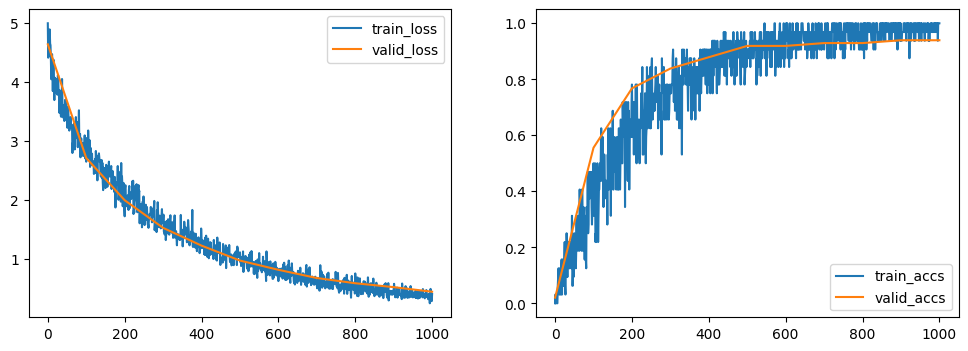

Training model 2/3
Evaluating at iteration:  0
Train, it: 0 loss: 4.94 accs: 0.00
Valid, it: 0 loss: 4.61 accs: 0.02

Evaluating at iteration:  100
Evaluating at iteration:  200
Evaluating at iteration:  300
Evaluating at iteration:  400
Evaluating at iteration:  500
Train, it: 500 loss: 0.98 accs: 0.91
Valid, it: 500 loss: 0.99 accs: 0.88

Evaluating at iteration:  600
Evaluating at iteration:  700
Evaluating at iteration:  800
Evaluating at iteration:  900
Evaluating at iteration:  1000
Train, it: 1000 loss: 0.37 accs: 1.00
Valid, it: 1000 loss: 0.45 accs: 0.96



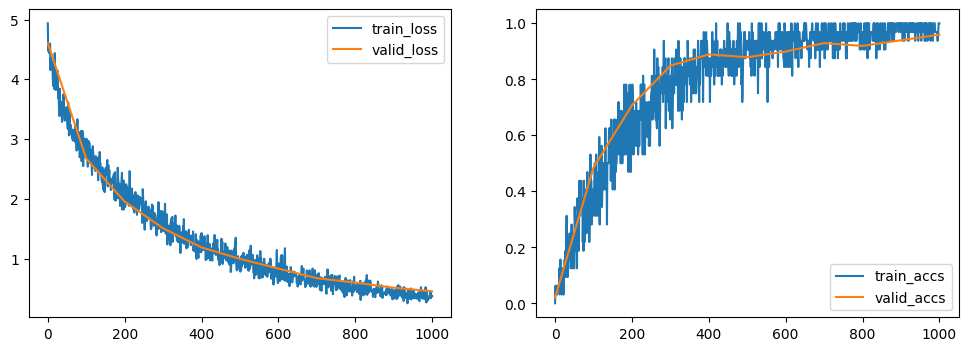

Training model 3/3
Evaluating at iteration:  0
Train, it: 0 loss: 4.86 accs: 0.03
Valid, it: 0 loss: 4.70 accs: 0.00

Evaluating at iteration:  100
Evaluating at iteration:  200
Evaluating at iteration:  300
Evaluating at iteration:  400
Evaluating at iteration:  500
Train, it: 500 loss: 1.10 accs: 0.91
Valid, it: 500 loss: 1.01 accs: 0.91

Evaluating at iteration:  600
Evaluating at iteration:  700
Evaluating at iteration:  800
Evaluating at iteration:  900
Evaluating at iteration:  1000
Train, it: 1000 loss: 0.30 accs: 1.00
Valid, it: 1000 loss: 0.47 accs: 0.96



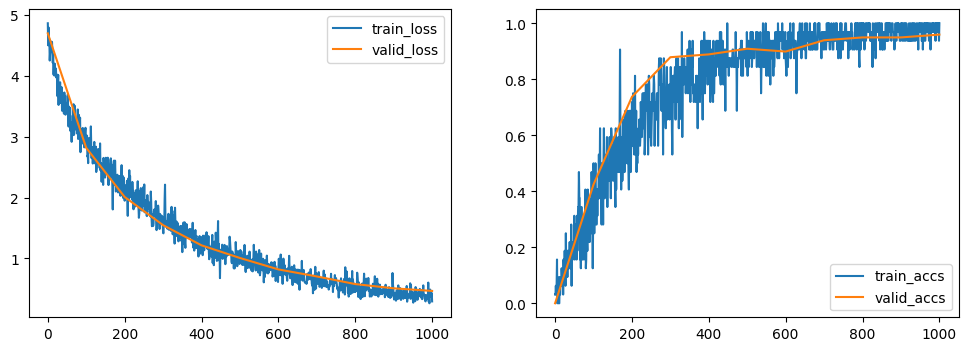

In [64]:
# Define the number of models in the ensemble
num_models = 3  # You can increase this number to strengthen the ensemble

# Store the trained models in a list
trained_models = []

# Train each model and store it in the list
for i in range(num_models):
    print(f"Training model {i + 1}/{num_models}")
    # Initialize a new model
    net = Net()
    # Move model to GPU if available
    net = net.cuda() if torch.cuda.is_available() else net
    # Define criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    # Train the model
    train_results = train_network_2(net, data_norm, criterion, optimizer, batch_size, NUM_CLASSES, max_iter=1000, log_every=500, eval_every=100, validation_size=0.1)
    # Add the trained model to the list
    trained_models.append(net)


In [70]:
# Create the ensemble model using the trained models
ensemble_model = EnsembleNet(trained_models)
# Move the ensemble model to GPU if available
ensemble_model = ensemble_model.cuda() if torch.cuda.is_available() else ensemble_model

# Evaluate the ensemble on the validation set
ensemble_model.eval()
val_losses, val_accs, val_lengths = 0, 0, 0
for batch_valid, num in batch_gen.gen_valid():
    output = ensemble_model(**get_input2(batch_valid, is_train=False))
    labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
    val_losses += criterion(output['out'], labels_argmax) * num
    val_accs += accuracy(output['out'], labels_argmax) * num
    val_lengths += num

# Calculate average validation loss and accuracy for the ensemble
val_loss_avg = val_losses / val_lengths
val_acc_avg = val_accs / val_lengths
print(f"Ensemble validation loss: {val_loss_avg:.4f}, accuracy: {val_acc_avg:.4f}")


Ensemble validation loss: 0.4465, accuracy: 0.9495


In [66]:
import torch
from torch.autograd import Variable
import pandas as pd
import numpy as np
from scipy.special import softmax

# Define the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble_model.to(device)  # Move the model to the selected device

# Function to perform predictions on the test set
def evaluate_on_test(net, batch_gen):
    ids_test, preds_test = [], []
    net.eval()  # Set the model to evaluation mode

    # Iterate over test data batches
    for batch_test, num in batch_gen.gen_test():
        # Prepare inputs using the `get_input` function
        inputs = get_input2(batch_test, is_train=False)
        
        # Move all inputs to the selected device
        inputs = {key: value.to(device) for key, value in inputs.items()}
        
        # Get model predictions
        with torch.no_grad():
            output = net(**inputs)
            logits = output['out'].data.cpu().numpy()  # Move logits back to CPU and convert to NumPy

        # Convert logits to probabilities using softmax
        probabilities = softmax(logits, axis=1)

        # Collect IDs and adjust output for the last batch if necessary
        ids_test += batch_test['ids']
        if num != len(probabilities):
            probabilities = probabilities[:num]  # Handle smaller last batch

        preds_test.append(probabilities)

    # Concatenate all predictions into a single array
    preds_test = np.concatenate(preds_test, axis=0)
    assert len(ids_test) == len(preds_test)

    return ids_test, preds_test

# Perform evaluation
ids_test, preds_test = evaluate_on_test(net, batch_gen)

# Create DataFrame for predictions using the class labels
preds_df = pd.DataFrame(preds_test, columns=data.le.classes_)  # Assuming `data.le` is a LabelEncoder for class labels
ids_test_df = pd.DataFrame(ids_test, columns=["id"])

# Concatenate IDs and probabilities into a single DataFrame for submission
submission = pd.concat([ids_test_df, preds_df], axis=1)

# Save the submission DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)

# Print the first 5 rows of the submission DataFrame to verify
print(submission.head(5))



   id  Acer_Capillipes  Acer_Circinatum  Acer_Mono  Acer_Opalus  \
0   4         0.000257         0.002087   0.000182     0.001115   
1   7         0.000212         0.000837   0.000684     0.003417   
2   9         0.001545         0.961595   0.000207     0.001103   
3  12         0.002439         0.001161   0.000124     0.000455   
4  13         0.001040         0.000852   0.000151     0.000256   

   Acer_Palmatum  Acer_Pictum  Acer_Platanoids  Acer_Rubrum  Acer_Rufinerve  \
0       0.001782     0.001246         0.000052     0.000278        0.001774   
1       0.000622     0.001365         0.001441     0.000588        0.000811   
2       0.001767     0.000468         0.001313     0.000775        0.000337   
3       0.000277     0.000099         0.000934     0.001566        0.001182   
4       0.000507     0.000147         0.000206     0.000534        0.000617   

   ...  Salix_Fragilis  Salix_Intergra  Sorbus_Aria  Tilia_Oliveri  \
0  ...        0.000202        0.000673     0.010915 

Using the ensemble method I get a score of 0.407

I will now try to extend the base network by giving it an extra convolutional layer

# Submission to Kaggle

First we have to make test set predictions, then we have to place the output in the submission file and then upload to Kaggle to get our score! You can upload up to 5 submissions per day.

In [67]:
"""
    
    

# GET PREDICTIONS
# containers to collect ids and predictions
ids_test, preds_test = [], []
net.eval()
# run like with validation
for batch_test, num in batch_gen.gen_test():
    output = net(**get_input(batch_test))
    y_out = output['out'].data

    ids_test += batch_test['ids']
    if num!=len(y_out):
        # in case of the last batch, num will be less than batch_size
        y_out = y_out[:num]
    preds_test.append(y_out)
preds_test = np.concatenate(preds_test, axis=0)
assert len(ids_test) == len(preds_test)


"""

"\n    \n    \n\n# GET PREDICTIONS\n# containers to collect ids and predictions\nids_test, preds_test = [], []\nnet.eval()\n# run like with validation\nfor batch_test, num in batch_gen.gen_test():\n    output = net(**get_input(batch_test))\n    y_out = output['out'].data\n\n    ids_test += batch_test['ids']\n    if num!=len(y_out):\n        # in case of the last batch, num will be less than batch_size\n        y_out = y_out[:num]\n    preds_test.append(y_out)\npreds_test = np.concatenate(preds_test, axis=0)\nassert len(ids_test) == len(preds_test)\n\n\n"

## Make submission file

In [68]:
"""preds_df = pd.DataFrame(preds_test, columns=data.le.classes_)
ids_test_df = pd.DataFrame(ids_test, columns=["id"])
submission = pd.concat([ids_test_df, preds_df], axis=1)
submission.to_csv(drive_path + 'submission.csv', index=False)

# below prints the submission, can be removed and replaced with code block below
submission.head(5) """

'preds_df = pd.DataFrame(preds_test, columns=data.le.classes_)\nids_test_df = pd.DataFrame(ids_test, columns=["id"])\nsubmission = pd.concat([ids_test_df, preds_df], axis=1)\nsubmission.to_csv(drive_path + \'submission.csv\', index=False)\n\n# below prints the submission, can be removed and replaced with code block below\nsubmission.head(5) '

## Upload submission

1. Go to [`https://www.kaggle.com/c/leaf-classification/submit`](https://www.kaggle.com/c/leaf-classification/submit)
3. Click or drop your submission here (writing a description is good practice)
4. Submit and look at where you are on the leaderboard.

Success! 